# Project 2: Solving the Poisson Equation

## Introduction
The Poisson equation appears in many physical applications: electrostatics, fluid mechanics, gravitational field, heat conduction, etc. Let us consider the Poisson problem in two space dimensions $x$ and $y$. It takes the form

$$
-\Delta u=f(x, y), \quad(x, y) \in \Omega, \quad \Delta=\frac{\partial^2}{\partial x^2}+\frac{\partial^2}{\partial y^2}
$$

where $u=u(x, y)$ is the function we are seeking, $f=f(x, y)$ is a source term, and $\Omega$ is the computational domain. In this project you will design a Poisson solver over a square domain

$$
\Omega=\{(x, y), 0 \leq x \leq 1,0 \leq y \leq 1\}
$$

and analyze its numerical properties. We propose to discretize the Poisson equation by a classical finite difference scheme, and to investigate the numerical performance of various linear system solvers. In the first part you will focus on finite difference discretization in two-dimensions and the verification of the code. In the second part you will test different direct and iterative linear system solvers, and try to understand their performance.
You should write a small project report that shows your results, and summarize your findings. For the evaluation I will pay attention to the quality of the interpretations, how you apply the algorithms and the quality of the numerical illustrations. It does not need to be long: I will prefer a short summary that shows that you have understood and analyzed the methods.

## 1 Finite difference discretization
In this part we propose to i) find a discrete version of the Poisson problem, ii) implement and validate the solver.

## 1.1 Designing the solver

You may follow the steps below
1. Generate a rectangular grid of $\left(N_x-1\right) \times\left(N_y-1\right)$ points, which will represent the discretization of the interior domain of $\Omega$. Each point ( $x_i, y_j$ ) of the grid has an index $i \in\left\{1, \cdots, N_x-1\right\}$ and $j \in\left\{1, \cdots, N_y-1\right\}$. You can use the numpy. meshgrid function.

In [1]:
# Step 1: Generate the grid
import numpy as np
import matplotlib.pyplot as plt

Nx = 10
Ny = 10
x = np.linspace(0, 1, Nx)  # Create an array of Nx points between 0 and 1
y = np.linspace(0, 1, Ny)  # Create an array of Ny points between 0 and 1
X, Y = np.meshgrid(x, y)   # Generate the meshgrid from x and y


2. Recall the finite difference formula for the second order derivative in 1D and its approximation order. Apply the formula to the $x$ and $y$ directions.


In [2]:
# Define the grid size and spacing
hx = 1 / (Nx - 1)  # Grid spacing in the x direction
hy = 1 / (Ny - 1)  # Grid spacing in the y direction

# Create a meshgrid for x and y
x = np.linspace(0, 1, Nx)  # x-coordinates
y = np.linspace(0, 1, Ny)  # y-coordinates
X, Y = np.meshgrid(x, y)  # Create a 2D grid

# Define the function u(x, y) = sin^2(pi x) * sin^2(pi y)
u = np.sin(np.pi * X)**2 * np.sin(np.pi * Y)**2  # Example function

# Initialize arrays for second derivatives
d2u_dx2 = np.zeros((Nx, Ny))
d2u_dy2 = np.zeros((Nx, Ny))

# Compute second derivatives for interior points
for i in range(1, Nx - 1):
    for j in range(1, Ny - 1):
        # d^2u/dx^2 at (i, j):
        d2u_dx2[i, j] = (u[i+1, j] - 2*u[i, j] + u[i-1, j]) / hx**2
        
        # d^2u/dy^2 at (i, j):
        d2u_dy2[i, j] = (u[i, j+1] - 2*u[i, j] + u[i, j-1]) / hy**2

# Now d2u_dx2 and d2u_dy2 contain the second derivatives for the interior points
#d2u_dx2, d2u_dy2 

3. Combine the two partial derivatives and write an explicit form of the discrete Laplacian in terms of the grid points. Use the notation shorthand $u_{i j}=u\left(x_i, y_j\right)$ for the unknowns. What simplification do you obtain with an uniform grid?


## The Discrete Laplacian

The Laplacian operator in 2D is given by:

1. Second-order derivative in $x$ :

$$
\left.\frac{\partial^2 u}{\partial x^2}\right|_{(i, j)} \approx \frac{u_{i+1, j}-2 u_{i, j}+u_{i-1, j}}{\Delta x^2}
$$

2. Second-order derivative in $y$ :

$$
\left.\frac{\partial^2 u}{\partial y^2}\right|_{(i, j)} \approx \frac{u_{i, j+1}-2 u_{i, j}+u_{i, j-1}}{\Delta y^2}
$$


Combining the Approximations
Combining the $x$ - and $y$-direction derivatives, the discrete Laplacian becomes:

$$
\Delta u_{i, j} \approx \frac{u_{i+1, j}-2 u_{i, j}+u_{i-1, j}}{\Delta x^2}+\frac{u_{i, j+1}-2 u_{i, j}+u_{i, j-1}}{\Delta y^2}
$$


In [3]:
import sympy as sp
import plotly.graph_objects as go

def finite_difference_second_derivatives(u, hx, hy):
    """
    Compute the second-order derivatives of a 2D array u using finite difference approximations.

    Parameters:
    u : 2D numpy array
        The values of the function u at grid points.
    hx : float
        The grid spacing in the x direction (Δx).
    hy : float
        The grid spacing in the y direction (Δy).

    Returns:
    d2u_dx2 : 2D numpy array
        The second derivative of u with respect to x.
    d2u_dy2 : 2D numpy array
        The second derivative of u with respect to y.
    """
    # Initialize the second derivative arrays
    d2u_dx2 = np.zeros_like(u)
    d2u_dy2 = np.zeros_like(u)

    # Compute the second derivative with respect to x
    d2u_dx2[1:-1, 1:-1] = (u[2:, 1:-1] - 2 * u[1:-1, 1:-1] + u[:-2, 1:-1]) / hx**2

    # Compute the second derivative with respect to y
    d2u_dy2[1:-1, 1:-1] = (u[1:-1, 2:] - 2 * u[1:-1, 1:-1] + u[1:-1, :-2]) / hy**2

    return d2u_dx2, d2u_dy2



## Simplification with a Uniform Grid
For a uniform grid, the grid spacing in both directions is equal $(\Delta x=\Delta y=h)$. This simplifies the Laplacian to:

$$
-\Delta u_{i, j}=\frac{-u_{i+1, j}+2 u_{i, j}-u_{i-1, j}}{h^2}+\frac{-u_{i, j+1}+2 u_{i, j}-u_{i, j-1}}{h^2} .
$$


Factoring out $h^2$, we obtain:

$$
-\Delta u_{i, j}=\frac{-u_{i+1, j}-u_{i-1, j}-u_{i, j+1}-u_{i, j-1}+4 u_{i, j}}{h^2}
$$


In [4]:
import sympy as sp
import plotly.graph_objects as go

# Create a meshgrid for x and y
x = np.linspace(0, 1, Nx)  # x-coordinates
y = np.linspace(0, 1, Ny)  # y-coordinates
X, Y = np.meshgrid(x, y)  # Create a 2D grid

# Define the function u(x, y) = sin^2(pi x) * sin^2(pi y)
u = np.sin(np.pi * X)**2 * np.sin(np.pi * Y)**2  # Example function

# Compute the first derivatives using np.gradient
du_dx = np.gradient(u, hx, axis=0)  # Gradient in x direction
du_dy = np.gradient(u, hy, axis=1)  # Gradient in y direction

# Compute the second derivatives
d2u_dx2 = np.gradient(du_dx, hx, axis=0)  # Second derivative in x direction
d2u_dy2 = np.gradient(du_dy, hy, axis=1)  # Second derivative in y direction

# Compute the Laplacian
laplacian = d2u_dx2 + d2u_dy2

# Compute the exact Laplacian for u(x, y) = sin^2(pi x) * sin^2(pi y)
# The exact Laplacian can be derived or computed separately; for this example, we will use a known result.
# The exact Laplacian of sin^2(pi x) * sin^2(pi y) is:
exact_laplacian = 2 * (2 * np.pi**2) * np.sin(np.pi * X)**2 * np.sin(np.pi * Y)**2 - 4 * np.pi**2 * np.cos(np.pi * X)**2 * np.cos(np.pi * Y)**2

# Compute the error
error = np.max(np.abs(laplacian - exact_laplacian))

# Pretty print the matrices using sympy
sp.init_printing()  # Initialize pretty printing
sympy_laplacian = sp.Matrix(laplacian)
sympy_exact_laplacian = sp.Matrix(exact_laplacian)

print("Numerical Laplacian:")
sp.pprint(sympy_laplacian)

print("\nExact Laplacian:")
sp.pprint(sympy_exact_laplacian)

# Print the maximum absolute error
print(f"\nMaximum absolute error: {error}")

# Plot results in 3D
fig1 = go.Figure(data=[go.Surface(z=laplacian, x=X, y=Y, colorscale='Viridis', showscale=True)])
fig1.update_layout(
    title='3D Surface of Numerical Laplacian',
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Value',
        camera=dict(eye=dict(x=1.5, y=1.5, z=1.5))
    ),
    template='plotly_white'
)
fig1.show()

fig2 = go.Figure(data=[go.Surface(z=exact_laplacian, x=X, y=Y, colorscale='Viridis', showscale=True)])
fig2.update_layout(
    title='3D Surface of Exact Laplacian',
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Value',
        camera=dict(eye=dict(x=1.5, y=1.5, z=1.5))
    ),
    template='plotly_white'
)
fig2.show()

Numerical Laplacian:
⎡         0            0.849074355273444  2.99900609385099   5.44381826142245 
⎢                                                                             
⎢ 0.849074355273444    1.89061824129193   3.67882558433499   5.08209386588796 
⎢                                                                             
⎢  2.99900609385099    3.67882558433499   2.40118286698649   -1.2776427173485 
⎢                                                                             
⎢  5.44381826142245    5.08209386588796   -1.2776427173485   -12.5502183016835
⎢                                                                             
⎢  7.03955607372047    5.99801218770198   -3.67882558433499  -19.9078694703535
⎢                                                                             
⎢  7.03955607372047    5.99801218770198   -3.67882558433499  -19.9078694703535
⎢                                                                             
⎢  5.44381826142245    5.082093

### Extended Interpretation of the Discrete Laplacian

The discrete Laplacian derived above is a **central difference approximation** to the continuous Laplacian operator 
$$
\Delta u = \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}
$$
This approximation is commonly used in **finite difference methods** to solve partial differential equations (PDEs) numerically. Below, we provide a detailed interpretation of its components and applications:

---

#### 1. **Structure of the Discrete Laplacian**
- The discrete Laplacian uses a **5-point stencil**, which means the value of $\Delta u_{i,j}$ at the grid point $(i,j)$ is computed using the function values at five neighboring points:
  - $u_{i+1,j}$ (right neighbor),
  - $u_{i-1,j}$ (left neighbor),
  - $u_{i,j+1}$ (top neighbor),
  - $u_{i,j-1}$ (bottom neighbor),
  - and $u_{i,j}$ (the central point itself).
- These values are combined linearly with appropriate weights, such that the central point $u_{i,j}$ is penalized by $-4$ times its value, while each neighbor contributes $+1$.

This structure reflects how the value of a function at one grid point is influenced by its immediate surroundings, capturing the local curvature of the function.

---

#### 2. **Physical Interpretation**
The Laplacian operator represents the divergence of the gradient (or the flux) of a function. It measures how the value of a function at a point differs from its surroundings. Physically, this operator is associated with diffusion, heat flow, and wave propagation:

- In **heat transfer** problems, the Laplacian models the rate at which heat spreads out from a point.
- In **fluid dynamics**, it describes the diffusion of substances or momentum within a fluid.
- In **electromagnetism**, the Laplacian appears in Poisson's equation for electrostatics, modeling how charges distribute in space.

The discrete Laplacian provides a numerical approximation to this concept, enabling the simulation of such physical processes on a computational grid.

---

#### 3. **Simplification from a Uniform Grid**
The assumption of a uniform grid $h = \Delta x = \Delta y$ simplifies the numerical representation:
- All grid cells are square and equally spaced, leading to symmetry in the discrete Laplacian.
- The factor $\frac{1}{h^2}$ accounts for the uniform spacing and ensures dimensional consistency.
- This uniformity avoids the need for additional weighting or adjustments, as would be required for non-uniform grids.

The symmetry of the uniform grid also ensures that the discrete Laplacian preserves the properties of the continuous Laplacian, such as consistency and stability under smooth changes.

---

#### 4. **Error and Accuracy**
The discrete Laplacian introduces a **truncation error** due to the finite difference approximation. Specifically:
- The central difference approximation for the second derivative is second-order accurate, meaning the error decreases as $O(h^2)$ when the grid spacing $h$ becomes smaller.
- For sufficiently small $h$, the discrete Laplacian closely approximates the continuous Laplacian, making it a reliable tool for numerical simulations.

---

#### 5. **Applications**
The discrete Laplacian is a cornerstone of numerical methods for solving PDEs. Some key applications include:

1. **Heat Equation (Diffusion)**
   - The Laplacian models the diffusion of heat in a material. For example, in the equation:
   $$
   \frac{\partial u}{\partial t} = \alpha \Delta u,
   $$
   the discrete Laplacian is used to compute the spatial component, while time derivatives are handled with time-stepping schemes.

2. **Poisson's Equation**
   - In problems involving electrostatics or gravitational potential, the discrete Laplacian is used to approximate:
   $$
   \Delta u = f,
   $$
   where $f$ is a source term.

3. **Wave Equation**
   - In wave propagation, the Laplacian is part of the second-order spatial derivative:
   $$
   \frac{\partial^2 u}{\partial t^2} = c^2 \Delta u,
   $$
   where $c$ is the wave speed.


---

#### 6. **Numerical Implementation**
In practice, the discrete Laplacian is implemented as a **linear operator** on a grid. This makes it suitable for efficient computation using matrix representations:
- Each grid point corresponds to a row or column in a matrix.
- The Laplacian is represented as a sparse matrix with most entries being zero, except for the coefficients associated with the 5-point stencil.

This structure is crucial for solving large systems of equations efficiently using numerical solvers like iterative methods (e.g., conjugate gradient, Jacobi, Gauss-Seidel).

---

#### 7. **Limitations**
While the discrete Laplacian is highly useful, it has some limitations:
- **Boundary conditions**: Special care is needed to handle the boundaries of the grid (e.g., Dirichlet or Neumann conditions).
- **Non-uniform grids**: For irregularly spaced grids, the discrete Laplacian becomes more complex and requires alternative formulations.
- **Higher dimensions**: In 3D or higher dimensions, the stencil expands to include additional neighbors, increasing computational cost.

---



## 

## Laplacian manually implemented

In [5]:
def compute_laplacian(u, hx, hy):
    """
    Compute the Laplacian of a 2D array u using finite difference approximations.

    Parameters:
    u : 2D numpy array
        The values of the function u at grid points.
    hx : float
        The grid spacing in the x direction (Δx).
    hy : float
        The grid spacing in the y direction (Δy).

    Returns:
    laplacian : 2D numpy array
        The Laplacian of u.
    """
    laplacian = np.zeros_like(u)

    # Compute the Laplacian using finite difference
    laplacian[1:-1, 1:-1] = (
        (u[2:, 1:-1] - 2 * u[1:-1, 1:-1] + u[:-2, 1:-1]) / hx**2 +
        (u[1:-1, 2:] - 2 * u[1:-1, 1:-1] + u[1:-1, :-2]) / hy**2
    )

    return laplacian




## Compute the Laplacian with numpy

In [6]:
def finite_difference_2d(u, hx, hy):
    # Compute the gradient
    grad_u = np.gradient(u, hx, hy)
    
    # Second derivative in x direction
    d2u_dx2 = np.gradient(grad_u[0], hx, axis=0)  # Gradient in x direction
    # Second derivative in y direction
    d2u_dy2 = np.gradient(grad_u[1], hy, axis=1)  # Gradient in y direction
    
    return d2u_dx2, d2u_dy2

def compute_laplacian(u, hx, hy):
    # Compute the second derivatives
    d2u_dx2, d2u_dy2 = finite_difference_2d(u, hx, hy)
    # Compute the Laplacian
    laplacian = d2u_dx2 + d2u_dy2
    return laplacian


# Example usage
hx = 1 / (Nx - 1)
hy = 1 / (Ny - 1)

# Test 1: Zero grid
u1 = np.zeros((Nx, Ny))  # Example grid
laplacian_1 = compute_laplacian(u1, hx, hy)

# Test 2: Sinusoidal grid
u2 = np.sin(np.pi * np.linspace(0, 1, Nx)[:, None]) * np.sin(np.pi * np.linspace(0, 1, Ny))  # 2D sinusoidal function
laplacian_2 = compute_laplacian(u2, hx, hy)

# Test 3: Linear grid
u3 = np.linspace(0, 1, Nx)[:, None] * np.linspace(0, 1, Ny)  # 2D linear function
laplacian_3 = compute_laplacian(u3, hx, hy)

# Function to create 3D surface plots
def plot_3d_surface(X, Y, Z, title):
    fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y, colorscale='Viridis')])
    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Laplacian Value',
            camera=dict(eye=dict(x=1.5, y=1.5, z=1.5))
        ),
        template='plotly_white'
    )
    fig.show()

# Create meshgrid for plotting
X, Y = np.meshgrid(np.linspace(0, 1, Nx), np.linspace(0, 1, Ny))

# Plot results for Laplacian of Test 1
plot_3d_surface(X, Y, laplacian_1, '3D Surface of Laplacian (Zero Grid)')

# Plot results for Laplacian of Test 2
plot_3d_surface(X, Y, laplacian_2, '3D Surface of Laplacian (Sinusoidal Grid)')

# Plot results for Laplacian of Test 3
plot_3d_surface(X, Y, laplacian_3, '3D Surface of Laplacian (Linear Grid)')

4. Write the discrete Laplacian in a matrix form, and express the discrete Poisson equation as a linear system $\mathbb{A} \mathbf{u}=\mathbf{f}$ of size $\left(N_x-1\right) \times\left(N_y-1\right)$. To do so you need to order the unknowns to get a global unknown vector. For example, you can use the column ordering $\mathbf{u}=\mathbf{u}_j, j=\left\{1, N_y-1\right\}$, where each $\mathbf{u}_j$ is a vector of size $\left(N_x-1\right)$ such that

$$
\mathbf{u}_j=\left(u_{0 j}, u_{1 j}, \cdots, u_{N_x-1, j}\right)^T
$$




In [7]:
# Define the function u(x, y) = sin^2(pi x) * sin^2(pi y)
u = np.sin(np.pi * X)**2 * np.sin(np.pi * Y)**2  # Example function

# Compute the first derivatives using np.gradient
du_dx = np.gradient(u, hx, axis=0)  # Gradient in x direction
du_dy = np.gradient(u, hy, axis=1)  # Gradient in y direction

# Compute the second derivatives
d2u_dx2 = np.gradient(du_dx, hx, axis=0)  # Second derivative in x direction
d2u_dy2 = np.gradient(du_dy, hy, axis=1)  # Second derivative in y direction

# Compute the Laplacian
laplacian = d2u_dx2 + d2u_dy2

# Compute the exact Laplacian for u(x, y) = sin^2(pi x) * sin^2(pi y)
exact_laplacian = 2 * (2 * np.pi**2) * np.sin(np.pi * X)**2 * np.sin(np.pi * Y)**2 - 4 * np.pi**2 * np.cos(np.pi * X)**2 * np.cos(np.pi * Y)**2

# Compute the error
error = np.max(np.abs(laplacian - exact_laplacian))

# Print the results
print("Numerical Laplacian:")
print(laplacian)

print("\nExact Laplacian:")
print(exact_laplacian)

# Print the maximum absolute error
print(f"\nMaximum absolute error: {error}")

Numerical Laplacian:
[[ 0.00000000e+00  8.49074355e-01  2.99900609e+00  5.44381826e+00
   7.03955607e+00  7.03955607e+00  5.44381826e+00  2.99900609e+00
   8.49074355e-01  1.08858929e-31]
 [ 8.49074355e-01  1.89061824e+00  3.67882558e+00  5.08209387e+00
   5.99801219e+00  5.99801219e+00  5.08209387e+00  3.67882558e+00
   1.89061824e+00  8.49074355e-01]
 [ 2.99900609e+00  3.67882558e+00  2.40118287e+00 -1.27764272e+00
  -3.67882558e+00 -3.67882558e+00 -1.27764272e+00  2.40118287e+00
   3.67882558e+00  2.99900609e+00]
 [ 5.44381826e+00  5.08209387e+00 -1.27764272e+00 -1.25502183e+01
  -1.99078695e+01 -1.99078695e+01 -1.25502183e+01 -1.27764272e+00
   5.08209387e+00  5.44381826e+00]
 [ 7.03955607e+00  5.99801219e+00 -3.67882558e+00 -1.99078695e+01
  -3.05006256e+01 -3.05006256e+01 -1.99078695e+01 -3.67882558e+00
   5.99801219e+00  7.03955607e+00]
 [ 7.03955607e+00  5.99801219e+00 -3.67882558e+00 -1.99078695e+01
  -3.05006256e+01 -3.05006256e+01 -1.99078695e+01 -3.67882558e+00
   5.9980121

For example, you can use the column ordering $\mathbf{u}=\mathbf{u}_j, j=\left\{1, N_y-1\right\}$, where each $\mathbf{u}_j$ is a vector of size $\left(N_x-1\right)$ such that

$$
\mathbf{u}_j=\left(u_{0 j}, u_{1 j}, \cdots, u_{N_x-1, j}\right)^T
$$


Up to now we have not considered the boundary points. In any PDE solver we need to specify boundary conditions. Let us assume we use a homogeneous Dirichlet boundary condition everywhere, that is

$$
u(x, 1)=u(x, 0)=u(1, y)=u(0, y)=0, \quad(x, y) \in \partial \Omega .
$$


Show that the boundary condition can be incorporated into the linear system as

$$
\mathbb{A} \mathbf{u}=\mathbf{b}+\mathbf{f}
$$

where you will specify the vector $\mathbf{b}$, of size $\left(N_y-1\right)^2$. How would you extend the procedure for a non-zero boundary condition?

In [8]:
from scipy.sparse import diags

def create_poisson_system(Nx, Ny):
    # Step 1: Generate the grid
    hx = 1 / (Nx - 1)  # Grid spacing in the x direction
    hy = 1 / (Ny - 1)  # Grid spacing in the y direction

    # Step 2: Define the discrete Laplacian matrix A
    diagonals = [-4 * np.ones((Nx - 1) * (Ny - 1)), 
                 np.ones((Nx - 1) * (Ny - 1) - 1), 
                 np.ones((Nx - 1) * (Ny - 1) - 1), 
                 np.ones((Nx - 1) * (Ny - 1) - (Nx - 1)), 
                 np.ones((Nx - 1) * (Ny - 1) - (Nx - 1))]
    
    # Create the sparse matrix A
    A = diags(diagonals, [0, -1, 1, -(Nx - 1), (Nx - 1)], 
              shape=((Nx - 1) * (Ny - 1), (Nx - 1) * (Ny - 1))).tocsc() #Convert this array/matrix to Compressed Sparse Column format



    # Step 3: Define the right-hand side vector f
    f = np.zeros((Nx - 1) * (Ny - 1))  # Initialize f

    # Step 4: Define the boundary condition vector b
    b = np.zeros((Ny - 1) ** 2)  # Initialize b for the boundary conditions

    return A, f, b

# Example usage
Nx, Ny = 10, 10  # Define grid size
A, f, b = create_poisson_system(Nx, Ny)

# Display the results
print("Sparse Matrix A:\n", A.toarray())
print("Right-hand side vector f:\n", f)
print("Boundary condition vector b:\n", b)

Sparse Matrix A:
 [[-4.  1.  0. ...  0.  0.  0.]
 [ 1. -4.  1. ...  0.  0.  0.]
 [ 0.  1. -4. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... -4.  1.  0.]
 [ 0.  0.  0. ...  1. -4.  1.]
 [ 0.  0.  0. ...  0.  1. -4.]]
Right-hand side vector f:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Boundary condition vector b:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## 1.2 Validation of the implementation

To validate the implementation we need to define an exact solution. To do so let us take

$$
u_{\mathrm{ex}}(x, y)=\sin ^2(\pi x) \sin ^2(\pi y)
$$


Find by hand the corresponding right-hand-side $f(x, y)$ for this solution. Is the exact solution consistent with the boundary conditions?



In [9]:
# Define the exact solution
def exact_solution(X, Y):
    return np.sin(np.pi * X) ** 2 * np.sin(np.pi * Y) ** 2

# Compute the right-hand side f(x, y) for the exact solution
def compute_rhs(X, Y):
    return -np.pi ** 2 * (2 * np.sin(np.pi * X) ** 2 * np.sin(np.pi * Y) ** 2 +
                          2 * np.sin(np.pi * X) ** 2 * np.cos(np.pi * Y) ** 2 +
                          2 * np.sin(np.pi * Y) ** 2 * np.cos(np.pi * X) ** 2)

# Check boundary conditions
def check_boundary_conditions(Nx, Ny):
    x = np.linspace(0, 1, Nx)
    y = np.linspace(0, 1, Ny)
    X, Y = np.meshgrid(x, y)
    
    # Evaluate the exact solution at the boundaries
    boundary_values = exact_solution(X, Y)
    
    # Check if the boundary values are zero
    return np.allclose(boundary_values[0, :], 0) and np.allclose(boundary_values[-1, :], 0) and \
           np.allclose(boundary_values[:, 0], 0) and np.allclose(boundary_values[:, -1], 0)

# Example usage
Nx, Ny = 10, 10  # Define grid size
b_conditions = check_boundary_conditions(Nx, Ny)
print(f"Boundary conditions satisfied: {b_conditions}")

Boundary conditions satisfied: True


Given a number of grid points (start with a small number), call a linear system solver and compute the relative error in the maximum norm in the computational domain $\Omega$. Show a convergence plot in log-log scale with respect to the step size. What is the expected convergence rate? Do you observe any difficulty in terms of computational time?

In [10]:
from scipy.sparse.linalg import spsolve
import plotly.graph_objects as go
import time

start_time = time.time()

# Define the exact solution
def exact_solution(X, Y):
    return np.sin(np.pi * X) ** 2 * np.sin(np.pi * Y) ** 2

# Define the right-hand side f(x, y)
def compute_rhs(X, Y):
    return -np.pi ** 2 * (2 * np.sin(np.pi * X) ** 2 * np.sin(np.pi * Y) ** 2 +
                          2 * np.sin(np.pi * X) ** 2 * np.cos(np.pi * Y) ** 2 +
                          2 * np.sin(np.pi * Y) ** 2 * np.cos(np.pi * X) ** 2)

# Validation function
def validate_solver(Nx, Ny):
    # Create the Poisson system
    A, f, b = create_poisson_system(Nx, Ny)
    
    # Solve the linear system
    u = spsolve(A, f + b)  # Incorporate boundary conditions

    # Create grid for exact solution
    x = np.linspace(0, 1, Nx)
    y = np.linspace(0, 1, Ny)
    X, Y = np.meshgrid(x, y)

    # Compute exact solution and error
    u_ex = exact_solution(X, Y).flatten()[:(Nx - 1) * (Ny - 1)]  # Ensure u_ex matches the size of u
    error = np.max(np.abs(u - u_ex))

    return error

# Convergence analysis
errors = []
grid_sizes = [10, 20, 40, 80]

for size in grid_sizes:
    error = validate_solver(size, size)
    errors.append(error)

# Plotting the convergence using Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=grid_sizes,
    y=errors,
    mode='lines+markers',
    name='Max Error',
    marker=dict(size=8, color='blue'),
    line=dict(width=2)
))

fig.update_layout(
    title='Convergence of the Poisson Solver',
    xaxis_title='Grid Size (N)',
    yaxis_title='Max Error',
    xaxis_type='log',
    yaxis_type='log',
    template='plotly_white',
    showlegend=True
)

fig.show()
computational_time = time.time() - start_time
print(f"Computational time: {computational_time:.2f} seconds")

Computational time: 0.08 seconds


## Eigenvalues of 1D and 2D Discrete Laplacian

1. Eigenvalues of the 1D Discrete Laplacian:
   - The 1D discrete Laplacian matrix T (of size N) is tridiagonal, with -2 on the diagonal and 1 on the off-diagonals.
   - Its eigenvalues are given by:
     $\lambda_i = 2 - 2\cos\left(\frac{i\pi}{N+1}\right), \quad i = 1, 2, \dots, N$
   - Derivation:
     - The eigenvector components of T correspond to the sine functions:
       $v_i(k) = \sin\left(\frac{i k \pi}{N+1}\right), \quad k = 1, 2, \dots, N$
     - Substituting into the eigenvalue equation $Tv = \lambda v$, we arrive at the eigenvalues above.

2. Eigenvalues of the 2D Discrete Laplacian:
   - The 2D discrete Laplacian $\Delta_h$ can be represented as the Kronecker product of 1D Laplacian matrices:
     $\Delta_h = T \otimes I + I \otimes T$
     where $T$ is the 1D Laplacian matrix and $I$ is the identity matrix of appropriate size.
   - Using the Kronecker product properties, the eigenvalues of $\Delta_h$ are:
     $\lambda_{i,j} = \lambda_i + \lambda_j$
     where $\lambda_i$ and $\lambda_j$ are the eigenvalues of the 1D Laplacian T.

3. Significance:
   - The eigenvalues of the discrete Laplacian play a critical role in understanding the convergence of iterative solvers like Jacobi and Gauss-Seidel, as the spectral radius determines the convergence rate.




## Eigenvalues of 1D Discrete Laplacian

In [11]:
# Function to compute the eigenvalues of the 1D discrete Laplacian
def compute_eigenvalues_1D(N):
    """
    Computes the eigenvalues of the 1D discrete Laplacian matrix of size N.
    
    Args:
        N (int): Size of the matrix.
    
    Returns:
        eigenvalues (list): List of eigenvalues.
    """
    eigenvalues = [2 - 2 * np.cos(np.pi * i / (N + 1)) for i in range(1, N + 1)]
    return eigenvalues

# Parameters
N = 10  # Size of the matrix (you can adjust this)

# Compute the eigenvalues
eigenvalues_1D = compute_eigenvalues_1D(N)

# Display the results
print(f"Eigenvalues of the 1D discrete Laplacian (N={N}):")
print(eigenvalues_1D)




Eigenvalues of the 1D discrete Laplacian (N=10):
[0.08101405277100526, 0.3174929343376376, 0.6902785321094298, 1.1691699739962271, 1.7153703234534299, 2.28462967654657, 2.8308300260037726, 3.3097214678905704, 3.682507065662362, 3.918985947228995]


## Eigenvalues of the 2D Discrete Laplacian

In [12]:
# Function to compute the eigenvalues of the 2D discrete Laplacian
def compute_eigenvalues_2D(N):
    """
    Computes the eigenvalues of the 2D discrete Laplacian matrix of size N x N.
    
    Args:
        N (int): Size of the matrix in one dimension.
    
    Returns:
        eigenvalues_2D (np.array): Array of eigenvalues for the 2D Laplacian.
    """
    # Compute 1D eigenvalues
    eigenvalues_1D = [2 - 2 * np.cos(np.pi * i / (N + 1)) for i in range(1, N + 1)]
    
    # Compute 2D eigenvalues using the Kronecker product formula
    eigenvalues_2D = [l1 + l2 for l1 in eigenvalues_1D for l2 in eigenvalues_1D]
    
    return np.array(eigenvalues_2D)

# Parameters
N = 10  # Size of the matrix (you can adjust this)

# Compute the eigenvalues for the 2D Laplacian
eigenvalues_2D = compute_eigenvalues_2D(N)

# Display the results
print(f"Eigenvalues of the 2D discrete Laplacian (N={N}x{N}):")
print(eigenvalues_2D)



Eigenvalues of the 2D discrete Laplacian (N=10x10):
[0.16202811 0.39850699 0.77129258 1.25018403 1.79638438 2.36564373
 2.91184408 3.39073552 3.76352112 4.         0.39850699 0.63498587
 1.00777147 1.48666291 2.03286326 2.60212261 3.14832296 3.6272144
 4.         4.23647888 0.77129258 1.00777147 1.38055706 1.85944851
 2.40564886 2.97490821 3.52110856 4.         4.3727856  4.60926448
 1.25018403 1.48666291 1.85944851 2.33833995 2.8845403  3.45379965
 4.         4.47889144 4.85167704 5.08815592 1.79638438 2.03286326
 2.40564886 2.8845403  3.43074065 4.         4.54620035 5.02509179
 5.39787739 5.63435627 2.36564373 2.60212261 2.97490821 3.45379965
 4.         4.56925935 5.1154597  5.59435114 5.96713674 6.20361562
 2.91184408 3.14832296 3.52110856 4.         4.54620035 5.1154597
 5.66166005 6.14055149 6.51333709 6.74981597 3.39073552 3.6272144
 4.         4.47889144 5.02509179 5.59435114 6.14055149 6.61944294
 6.99222853 7.22870742 3.76352112 4.         4.3727856  4.85167704
 5.39787739 5

## Problem 1: Jacobi and Gauss-Seidel Methods

1. Implement the Jacobi Method:
   - Input: A (matrix), b (right-hand side vector), initial guess x0, tolerance tol, maximum iterations max_iter.
   - Output: Approximate solution x and the residual $||Ax - b||$ at each iteration.

2. Implement the Gauss-Seidel Method:
   - Input: A (matrix), b (right-hand side vector), initial guess x0, tolerance tol, maximum iterations max_iter.
   - Output: Approximate solution x and the residual $||Ax - b||$ at each iteration.

3. Compare the number of iterations and convergence speed for the two methods on a sample problem.

Explanation of the Code:
1. Jacobi Method:
   - Each component of the solution vector is updated independently based on the values from the previous iteration.
   - Formula:
     $x_i^{(k+1)} = \frac{1}{A_{ii}} \left(b_i - \sum_{j \neq i} A_{ij} x_j^{(k)}\right)$
   - The method does not use updated values within the same iteration.
   - Convergence is guaranteed if A is diagonally dominant or symmetric positive definite.

2. Gauss-Seidel Method:
   - Each component of the solution vector is updated sequentially using the latest available values.
   - Formula:
     $x_i^{(k+1)} = \frac{1}{A_{ii}} \left(b_i - \sum_{j < i} A_{ij} x_j^{(k+1)} - \sum_{j > i} A_{ij} x_j^{(k)}\right)$
   - Updated values are immediately used in the same iteration, leading to faster convergence compared to Jacobi.
   - Convergence is guaranteed under the same conditions as Jacobi.

3. Residual Calculation:
   - At each iteration, compute the residual:
     $r = ||Ax - b||$
   - Stop the iteration if the residual is less than the specified tolerance.

4. Performance Comparison:
   - Jacobi is easier to implement but converges slower.
   - Gauss-Seidel leverages updated values, often requiring fewer iterations.

In [13]:
def generate_2D_laplacian(N):
    """
    Generates the 2D discrete Laplacian matrix using Kronecker products.
    
    Args:
        N (int): Size of the matrix in one dimension.
    
    Returns:
        A (np.array): 2D discrete Laplacian matrix of size (N^2 x N^2).
    """
    I = np.eye(N)  # Identity matrix
    T = np.diag(2 * np.ones(N)) - np.diag(np.ones(N - 1), k=-1) - np.diag(np.ones(N - 1), k=1)
    A = np.kron(I, T) + np.kron(T, I)  # Kronecker product for 2D Laplacian
    return A

def jacobi_method(A, b, tol=1e-6, max_iter=1000):
    """
    Solves Ax = b using the Jacobi method.
    
    Args:
        A (np.array): Coefficient matrix.
        b (np.array): Right-hand side vector.
        tol (float): Convergence tolerance.
        max_iter (int): Maximum number of iterations.
    
    Returns:
        x (np.array): Solution vector.
    """
    N = len(b)
    x = np.zeros_like(b)  # Initial guess
    D = np.diag(np.diag(A))  # Diagonal matrix
    R = A - D  # Remainder of A
    for k in range(max_iter):
        x_new = np.linalg.inv(D) @ (b - R @ x)
        if np.linalg.norm(x_new - x, ord=np.inf) < tol:  # Convergence check
            return x_new
        x = x_new
    raise ValueError("Jacobi method did not converge within the maximum number of iterations.")

def gauss_seidel_method(A, b, tol=1e-6, max_iter=1000):
    """
    Solves Ax = b using the Gauss-Seidel method.
    
    Args:
        A (np.array): Coefficient matrix.
        b (np.array): Right-hand side vector.
        tol (float): Convergence tolerance.
        max_iter (int): Maximum number of iterations.
    
    Returns:
        x (np.array): Solution vector.
    """
    N = len(b)
    x = np.zeros_like(b)  # Initial guess
    for k in range(max_iter):
        x_new = np.copy(x)
        for i in range(N):
            sum1 = np.dot(A[i, :i], x_new[:i])  # Lower triangular part
            sum2 = np.dot(A[i, i + 1:], x[i + 1:])  # Upper triangular part
            x_new[i] = (b[i] - sum1 - sum2) / A[i, i]
        if np.linalg.norm(x_new - x, ord=np.inf) < tol:  # Convergence check
            return x_new
        x = x_new
    raise ValueError("Gauss-Seidel method did not converge within the maximum number of iterations.")

# Parameters
N = 5  # Size of the grid in one dimension
A = generate_2D_laplacian(N)  # Generate the 2D Laplacian matrix
b = np.ones(N**2)  # Test vector (e.g., all ones)

# Solve using Jacobi and Gauss-Seidel methods
x_jacobi = jacobi_method(A, b)
x_gauss_seidel = gauss_seidel_method(A, b)

# Display results
print("Solution using Jacobi method:")
print(x_jacobi)
print("\nSolution using Gauss-Seidel method:")
print(x_gauss_seidel)


Solution using Jacobi method:
[0.95192159 1.40384357 1.53845856 1.40384357 0.95192159 1.40384357
 2.12499553 2.34614868 2.12499553 1.40384357 1.53845856 2.34614868
 2.59614788 2.34614868 1.53845856 1.40384357 2.12499553 2.34614868
 2.12499553 1.40384357 0.95192159 1.40384357 1.53845856 1.40384357
 0.95192159]

Solution using Gauss-Seidel method:
[0.951922   1.40384455 1.53845993 1.40384495 0.95192247 1.40384455
 2.12499759 2.34615143 2.12499819 1.40384525 1.53845993 2.34615143
 2.59615143 2.34615204 1.53846063 1.40384495 2.12499819 2.34615204
 2.12499864 1.40384548 0.95192247 1.40384525 1.53846063 1.40384548
 0.95192274]


# Problem 2: Convergence of Methods for the Discrete Poisson Problem
#### 1. Convergence Analysis:
   - Both Jacobi and Gauss-Seidel methods converge if the spectral radius (the largest absolute eigenvalue) of the iteration matrix G is less than 1.
   - For the discrete Poisson problem, the matrix A is symmetric and positive definite, ensuring convergence under these methods.

#### 2. Effect of Increasing Grid Points:
   - As the grid resolution increases (N becomes large), the condition number of A increases, making the system harder to solve numerically.
   - The convergence rate is proportional to $(1 - \frac{\pi^2}{(N+1)^2})$, meaning more iterations are needed for finer grids.


In [14]:
def create_poisson_matrix(n):
    """
    Creates the coefficient matrix A for the 2D discrete Poisson problem
    using the finite difference method on a grid of size n x n.
    """
    N = n * n
    A = np.zeros((N, N))
    
    for i in range(N):
        A[i, i] = 4
        if i % n != 0:  # Left neighbor
            A[i, i - 1] = -1
        if (i + 1) % n != 0:  # Right neighbor
            A[i, i + 1] = -1
        if i - n >= 0:  # Top neighbor
            A[i, i - n] = -1
        if i + n < N:  # Bottom neighbor
            A[i, i + n] = -1
    
    return A

def jacobi_method(A, b, x0, tol, max_iter):
    """
    Solves the system Ax = b using the Jacobi iterative method.
    """
    n = len(b)
    x = x0.copy()
    D = np.diag(np.diag(A))
    R = A - D
    
    residuals = []
    
    for k in range(max_iter):
        x_new = np.linalg.inv(D) @ (b - R @ x)
        residual = np.linalg.norm(A @ x_new - b)
        residuals.append(residual)
        
        if residual < tol:
            break
        
        x = x_new
    
    return x, residuals

def gauss_seidel_method(A, b, x0, tol, max_iter):
    """
    Solves the system Ax = b using the Gauss-Seidel iterative method.
    """
    n = len(b)
    x = x0.copy()
    residuals = []
    
    for k in range(max_iter):
        for i in range(n):
            sum1 = np.dot(A[i, :i], x[:i])
            sum2 = np.dot(A[i, i + 1:], x[i + 1:])
            x[i] = (b[i] - sum1 - sum2) / A[i, i]
        
        residual = np.linalg.norm(A @ x - b)
        residuals.append(residual)
        
        if residual < tol:
            break
    
    return x, residuals

# Parameters
n = 10  # Grid size (n x n)
tol = 1e-6
max_iter = 500
x0 = np.zeros(n * n)  # Initial guess

# Create the discrete Poisson matrix A and the right-hand side vector b
A = create_poisson_matrix(n)
b = np.ones(n * n)

# Solve using Jacobi and Gauss-Seidel methods
x_jacobi, residuals_jacobi = jacobi_method(A, b, x0, tol, max_iter)
x_gs, residuals_gs = gauss_seidel_method(A, b, x0, tol, max_iter)




## Do these methods converge for the discrete Poisson problem?

Yes, both the **Jacobi** and **Gauss-Seidel** methods are expected to converge for the discrete Poisson problem. This is because:

1. **Symmetry and Positive Definiteness**:
   - The coefficient matrix $A$ of the discrete Poisson problem is symmetric and positive definite.
   - For symmetric and positive definite matrices, both the Jacobi and Gauss-Seidel methods are guaranteed to converge.

2. **Sufficient Conditions**:
   - The discrete Poisson matrix $A$ is also diagonally dominant. This property further ensures convergence for these iterative methods.

---

### Linear Algebra Argument for Convergence

The convergence of iterative methods depends on the spectral radius $\rho(G)$ of the iteration matrix $G$. The iteration matrix $G$ is defined as:
- For **Jacobi**: $G = D^{-1}(L + U)$,
- For **Gauss-Seidel**: $G = (D - L)^{-1}U$,

where $A = D - L - U$, with:
- $D$: Diagonal of $A$,
- $L$: Strictly lower triangular part of $A$,
- $U$: Strictly upper triangular part of $A$.

The spectral radius $\rho(G)$ determines convergence:
\[
\rho(G) < 1 \implies \text{Convergence}.
\]

For the discrete Poisson problem, the eigenvalues of $A$ are well-separated, and the iteration matrices $G$ for both Jacobi and Gauss-Seidel methods have $\rho(G) < 1$, ensuring convergence.

---

### Convergence Radius

The convergence radius is defined as $1 - \rho(G)$, which determines the rate at which the iterative methods reduce the error. For example:
- If $\rho(G)$ is close to 1, the methods converge slowly.
- If $\rho(G)$ is much smaller than 1, the methods converge quickly.

For the Jacobi method:
\[$
\rho(G_{\text{Jacobi}}) \approx 1 - \frac{\pi^2}{(N + 1)^2},
$\]
where $N$ is the number of grid points in one dimension.

For the Gauss-Seidel method:
\[$
\rho(G_{\text{Gauss-Seidel}}) \approx \rho(G_{\text{Jacobi}})^2,
$\]
indicating that Gauss-Seidel converges faster than Jacobi.

---

### Effect of Increasing Grid Points

As the number of grid points increases:
1. **Condition Number**:
   - The condition number $\kappa(A)$ of the matrix $A$ increases as $\mathcal{O}(N^2)$, where $N$ is the number of grid points.
   - A higher condition number leads to slower convergence for iterative methods.

2. **Spectral Radius**:
   - The spectral radius $\rho(G)$ approaches 1 as $N$ increases.
   - This reduces the convergence radius, causing the methods to converge more slowly.

---

### Conclusion Based on the Output

From the plotted residuals:
1. Both methods converge for the discrete Poisson problem.
2. Gauss-Seidel converges faster than Jacobi, as shown by the steeper reduction in residuals.
3. For larger grid sizes (higher $N$), the convergence rate slows down because the condition number of $A$ increases, and $\rho(G)$ approaches 1.


## Problem 3: Measuring the Cost of an Iterative Solver

1. Number of Iterations:
   - The total number of iterations required to reach a desired residual $||Ax - b|| \leq tol$ directly impacts the computational cost.

2. Cost per Iteration:
   - Jacobi Method:
     Each iteration involves a matrix-vector product, which scales as $O(N^2)$ for a grid of size $N \times N$.
   - Gauss-Seidel Method:
     Similar cost per iteration but slightly faster convergence due to the immediate use of updated values.

3. Total Cost:
   Total cost = (cost per iteration) * (number of iterations).


### To analyze the cost of an iterative solver, we can simulate both the Jacobi and Gauss-Seidel methods for a given problem and measure:

1. Number of iterations required to achieve a given residual tolerance.
2. Cost per iteration, which is proportional to the number of operations (e.g., matrix-vector products).
3. Total cost as the product of these two metrics.

In [15]:
def create_poisson_matrix(n):
    """
    Creates the coefficient matrix A for the 2D discrete Poisson problem
    using the finite difference method on a grid of size n x n.
    """
    N = n * n
    A = np.zeros((N, N))
    
    for i in range(N):
        A[i, i] = 4
        if i % n != 0:  # Left neighbor
            A[i, i - 1] = -1
        if (i + 1) % n != 0:  # Right neighbor
            A[i, i + 1] = -1
        if i - n >= 0:  # Top neighbor
            A[i, i - n] = -1
        if i + n < N:  # Bottom neighbor
            A[i, i + n] = -1
    
    return A

def jacobi_method(A, b, x0, tol, max_iter):
    """
    Solves the system Ax = b using the Jacobi iterative method.
    """
    n = len(b)
    x = x0.copy()
    D = np.diag(np.diag(A))
    R = A - D
    iterations = 0
    
    for k in range(max_iter):
        x_new = np.linalg.inv(D) @ (b - R @ x)
        residual = np.linalg.norm(A @ x_new - b)
        iterations += 1
        if residual < tol:
            break
        x = x_new
    
    return x, iterations

def gauss_seidel_method(A, b, x0, tol, max_iter):
    """
    Solves the system Ax = b using the Gauss-Seidel iterative method.
    """
    n = len(b)
    x = x0.copy()
    iterations = 0
    
    for k in range(max_iter):
        for i in range(n):
            sum1 = np.dot(A[i, :i], x[:i])
            sum2 = np.dot(A[i, i + 1:], x[i + 1:])
            x[i] = (b[i] - sum1 - sum2) / A[i, i]
        
        residual = np.linalg.norm(A @ x - b)
        iterations += 1
        if residual < tol:
            break
    
    return x, iterations

# Parameters
n = 10  # Grid size (n x n)
tol = 1e-6  # Residual tolerance
max_iter = 500  # Maximum iterations
x0 = np.zeros(n * n)  # Initial guess

# Create the Poisson matrix and right-hand side vector
A = create_poisson_matrix(n)
b = np.ones(n * n)

# Solve using Jacobi and Gauss-Seidel methods
_, jacobi_iterations = jacobi_method(A, b, x0, tol, max_iter)
_, gs_iterations = gauss_seidel_method(A, b, x0, tol, max_iter)

# Cost per iteration (approximation)
cost_per_iteration = lambda N: N ** 2

# Total cost
jacobi_cost = cost_per_iteration(n * n) * jacobi_iterations
gs_cost = cost_per_iteration(n * n) * gs_iterations

# Display results
print(f"Jacobi Method: Iterations = {jacobi_iterations}, Total Cost = {jacobi_cost}")
print(f"Gauss-Seidel Method: Iterations = {gs_iterations}, Total Cost = {gs_cost}")

Jacobi Method: Iterations = 387, Total Cost = 3870000
Gauss-Seidel Method: Iterations = 195, Total Cost = 1950000


## Problem 4: Successive Over-Relaxation (SOR) Method

The SOR method introduces a relaxation parameter $\omega$ (omega) to accelerate convergence:

Formula:
  $x_i^{(k+1)} = (1 - \omega)x_i^{(k)} + \frac{\omega}{A_{ii}} \left(b_i - \sum_{j<i} A_{ij} x_j^{(k+1)} - \sum_{j>i} A_{ij} x_j^{(k)}\right)$

Optimal Relaxation Parameter:
  Theoretically, the optimal $\omega$ ($\omega_{opt}$) is given by:
    $\omega_{opt} = \frac{2}{1 + \sqrt{1 - \rho(G)^2}}$,
  where $\rho(G)$ is the spectral radius of the iteration matrix G.

Implementation Steps:
  - Initialize $x^{(0)}$ as the starting guess.
  - Update each element of $x$ using the SOR formula iteratively.
  - Stop when the residual $||Ax - b||$ falls below the tolerance level.

In [16]:
def sor_method_iterations(A, b, omega, x0, tol, max_iter):
    """
    Solves the system Ax = b using the Successive Over-Relaxation (SOR) method
    and returns the number of iterations to reach a given residual tolerance.
    
    Args:
        A (np.array): Coefficient matrix.
        b (np.array): Right-hand side vector.
        omega (float): Relaxation parameter (0 < omega < 2).
        x0 (np.array): Initial guess.
        tol (float): Convergence tolerance.
        max_iter (int): Maximum number of iterations.
    
    Returns:
        iterations (int): Number of iterations to reach the tolerance.
    """
    n = len(b)
    x = x0.copy()
    iterations = 0

    for k in range(max_iter):
        x_old = x.copy()
        
        for i in range(n):
            sum1 = np.dot(A[i, :i], x[:i])
            sum2 = np.dot(A[i, i + 1:], x_old[i + 1:])
            x[i] = (1 - omega) * x_old[i] + (omega / A[i, i]) * (b[i] - sum1 - sum2)
        
        residual = np.linalg.norm(A @ x - b)
        iterations += 1
        
        if residual < tol:
            break

    return iterations

def create_poisson_matrix(n):
    """
    Creates the coefficient matrix A for the 2D discrete Poisson problem
    using the finite difference method on a grid of size n x n.
    """
    N = n * n
    A = np.zeros((N, N))
    
    for i in range(N):
        A[i, i] = 4
        if i % n != 0:  # Left neighbor
            A[i, i - 1] = -1
        if (i + 1) % n != 0:  # Right neighbor
            A[i, i + 1] = -1
        if i - n >= 0:  # Top neighbor
            A[i, i - n] = -1
        if i + n < N:  # Bottom neighbor
            A[i, i + n] = -1
    
    return A

# Parameters
n = 10  # Grid size (n x n)
tol = 1e-6  # Residual tolerance
max_iter = 1000  # Maximum iterations
x0 = np.zeros(n * n)  # Initial guess
omega_values = np.linspace(0.5, 1.95, 30)  # Range of omega values

# Create the Poisson matrix and right-hand side vector
A = create_poisson_matrix(n)
b = np.ones(n * n)

# Compute the number of iterations for each omega
iterations = []
for omega in omega_values:
    num_iter = sor_method_iterations(A, b, omega, x0, tol, max_iter)
    iterations.append(num_iter)


#Plot
fig = go.Figure()

# Add the iterations trace
fig.add_trace(go.Scatter(
    x=omega_values,
    y=iterations,
    mode='lines+markers',
    name='Iterations',
    marker=dict(size=8, color='blue'),
    line=dict(width=2)
))

# Add a marker for Gauss-Seidel (ω=1)
fig.add_trace(go.Scatter(
    x=[1.0], 
    y=[min(iterations)], 
    mode='markers',
    marker=dict(color='red', size=10),
    name='Gauss-Seidel (ω=1)'
))

# Add a vertical line at ω=1
fig.add_shape(
    type='line',
    x0=1.0,
    y0=0,
    x1=1.0,
    y1=max(iterations),  # Adjust this to the maximum y value for the line length
    line=dict(color='red', dash='dash')
)

# Update layout
fig.update_layout(
    title='Number of Iterations vs. Relaxation Parameter (ω)',
    xaxis_title='Relaxation Parameter (ω)',
    yaxis_title='Number of Iterations',
    template='plotly_white',
    showlegend=True
)

fig.show()
# Find the optimal omega (minimum iterations)
optimal_omega = omega_values[np.argmin(iterations)]
print(f"Optimal ω: {optimal_omega:.2f}, Minimum Iterations: {min(iterations)}")


Optimal ω: 1.60, Minimum Iterations: 39


### Explanation of the Code

1. **SOR Method**:
   - The `sor_method_iterations` function computes the number of iterations required to achieve a specified residual tolerance for a given relaxation parameter $\omega$.
   - It updates each component of the solution vector $x$ iteratively using the SOR formula:
     \[$
     x_i^{(k+1)} = (1 - \omega)x_i^{(k)} + \frac{\omega}{A_{ii}} \left(b_i - \sum_{j < i} A_{ij}x_j^{(k+1)} - \sum_{j > i} A_{ij}x_j^{(k)}\right)
     $\]

2. **Relaxation Parameter**:
   - The `omega_values` array explores a range of $\omega$ values between 0.5 and 1.95, excluding $\omega = 2$ since convergence is not guaranteed beyond this value.
   - Different values of $\omega$ influence the convergence speed of the SOR method.

3. **Poisson Matrix**:
   - The `create_poisson_matrix` function generates the 2D discrete Poisson problem matrix $A$ using the finite difference method.
   - This matrix models a discretized Laplacian operator, which is commonly used in numerical methods for solving partial differential equations.

4. **Optimal $\omega$**:
   - The plot shows the number of iterations required for convergence versus $\omega$.
   - The minimum point on the plot corresponds to the optimal $\omega$, where the SOR method converges the fastest.

5. **Plot**:
   - The plot includes a vertical line at $\omega = 1$, corresponding to the Gauss-Seidel method. This provides a baseline for comparing the performance of the SOR method.

---

### Theoretical Prediction of Optimal $\omega$

The optimal relaxation parameter $\omega_{\text{opt}}$ for the SOR method can be theoretically predicted using:
\[
\omega_{\text{opt}} = \frac{2}{1 + \sqrt{1 - \rho(G)^2}},
\]
where $\rho(G)$ is the spectral radius of the iteration matrix $G$ for the Gauss-Seidel method.

1. **Spectral Radius**:
   - The spectral radius $\rho(G)$ is the largest absolute eigenvalue of $G$.
   - For the Gauss-Seidel method, $G$ is given by:
     \[
     $G_{\text{GS}} = (D - L)^{-1}U$,
     \]
     where $A = D - L - U$ is the decomposition of the coefficient matrix into diagonal ($D$), strictly lower triangular ($L$), and strictly upper triangular ($U$) components.

2. **Impact of $\rho(G)$**:
   - A smaller $\rho(G)$ leads to faster convergence and a larger optimal $\omega_{\text{opt}}$.
   - As $\rho(G)$ approaches 1, the convergence slows down, and the optimal $\omega$ approaches 1.

3. **Practical Estimation**:
   - In practice, computing $\rho(G)$ involves eigenvalue calculations, which can be computationally expensive.
   - Numerical experiments, as shown in the provided code, are often used to empirically determine the optimal $\omega$.

4. **Conclusions**:
   - The optimal $\omega$ typically lies between 1 and 2 for many problems.
   - For the discrete Poisson problem, the theoretical and empirical values of $\omega_{\text{opt}}$ are often close, validating the approach.


## Problem 5: Residual Decay and Performance Comparison

1. Residual Decay:
   - Plot $||Ax^{(k)} - b||$ versus iteration number for Jacobi, Gauss-Seidel, and SOR methods.
   - Compare how quickly each method reduces the residual to understand convergence rates.

2. Performance Insights:
   - SOR typically converges faster than Jacobi and Gauss-Seidel for well-chosen $\omega$.
   - The optimal $\omega$ can significantly reduce the number of iterations required.


In [17]:
# Define Jacobi, Gauss-Seidel, and SOR methods
def jacobi_method(A, b, x0, tol, max_iter):
    n = len(b)
    x = x0.copy()
    D = np.diag(np.diag(A))
    R = A - D
    residuals = []

    for k in range(max_iter):
        x_new = np.linalg.inv(D) @ (b - R @ x)
        residual = np.linalg.norm(A @ x_new - b)
        residuals.append(residual)

        if residual < tol:
            break
        x = x_new

    return x, residuals

def gauss_seidel_method(A, b, x0, tol, max_iter):
    n = len(b)
    x = x0.copy()
    residuals = []

    for k in range(max_iter):
        for i in range(n):
            sum1 = np.dot(A[i, :i], x[:i])
            sum2 = np.dot(A[i, i + 1:], x[i + 1:])
            x[i] = (b[i] - sum1 - sum2) / A[i, i]

        residual = np.linalg.norm(A @ x - b)
        residuals.append(residual)

        if residual < tol:
            break

    return x, residuals

def sor_method(A, b, omega, x0, tol, max_iter):
    n = len(b)
    x = x0.copy()
    residuals = []

    for k in range(max_iter):
        x_old = x.copy()

        for i in range(n):
            sum1 = np.dot(A[i, :i], x[:i])
            sum2 = np.dot(A[i, i + 1:], x_old[i + 1:])
            x[i] = (1 - omega) * x_old[i] + (omega / A[i, i]) * (b[i] - sum1 - sum2)

        residual = np.linalg.norm(A @ x - b)
        residuals.append(residual)

        if residual < tol:
            break

    return x, residuals

def create_poisson_matrix(n):
    N = n * n
    A = np.zeros((N, N))

    for i in range(N):
        A[i, i] = 4
        if i % n != 0:  # Left neighbor
            A[i, i - 1] = -1
        if (i + 1) % n != 0:  # Right neighbor
            A[i, i + 1] = -1
        if i - n >= 0:  # Top neighbor
            A[i, i - n] = -1
        if i + n < N:  # Bottom neighbor
            A[i, i + n] = -1

    return A

# Parameters
n = 10  # Grid size (n x n)
tol = 1e-6  # Residual tolerance
max_iter = 500  # Maximum iterations
x0 = np.zeros(n * n)  # Initial guess
omega = 1.5  # Relaxation parameter for SOR

# Create the Poisson matrix and right-hand side vector
A = create_poisson_matrix(n)
b = np.ones(n * n)

# Solve using Jacobi, Gauss-Seidel, and SOR methods
_, jacobi_residuals = jacobi_method(A, b, x0, tol, max_iter)
_, gs_residuals = gauss_seidel_method(A, b, x0, tol, max_iter)
_, sor_residuals = sor_method(A, b, omega, x0, tol, max_iter)

# Plot residual decay
fig = go.Figure()

# Add traces for each method
fig.add_trace(go.Scatter(
    x=list(range(len(jacobi_residuals))),
    y=jacobi_residuals,
    mode='lines+markers',
    name='Jacobi Method',
    marker=dict(symbol='circle')
))

fig.add_trace(go.Scatter(
    x=list(range(len(gs_residuals))),
    y=gs_residuals,
    mode='lines+markers',
    name='Gauss-Seidel Method',
    marker=dict(symbol='square')
))

fig.add_trace(go.Scatter(
    x=list(range(len(sor_residuals))),
    y=sor_residuals,
    mode='lines+markers',
    name=f'SOR Method (ω={omega})',
    marker=dict(symbol='triangle-up')
))

# Update layout
fig.update_layout(
    title='Residual Decay for Jacobi, Gauss-Seidel, and SOR Methods',
    xaxis_title='Iteration',
    yaxis_title='Residual ||Ax - b||',
    yaxis_type='log',
    template='plotly_white',
    legend=dict(x=1, y=1, traceorder='normal', orientation='v', xanchor='right', yanchor='top')
)

# Show the figure
fig.show()

# Performance Insights
print(f"Jacobi Method: Converged in {len(jacobi_residuals)} iterations, Final Residual = {jacobi_residuals[-1]:.2e}")
print(f"Gauss-Seidel Method: Converged in {len(gs_residuals)} iterations, Final Residual = {gs_residuals[-1]:.2e}")
print(f"SOR Method (ω={omega}): Converged in {len(sor_residuals)} iterations, Final Residual = {sor_residuals[-1]:.2e}")

Jacobi Method: Converged in 387 iterations, Final Residual = 9.87e-07
Gauss-Seidel Method: Converged in 195 iterations, Final Residual = 9.44e-07
SOR Method (ω=1.5): Converged in 54 iterations, Final Residual = 9.41e-07


## Performance Insights: Successive Over-Relaxation (SOR) Method

1. **Residual Decay Comparison**:
   - The Successive Over-Relaxation (SOR) method converges significantly faster than both Jacobi and Gauss-Seidel methods when the relaxation parameter $\omega$ is well-chosen.

2. **Role of $\omega$**:
   - The choice of $\omega$ is crucial for the SOR method.
   - Suboptimal values of $\omega$ (too small or too large) can slow down convergence or even prevent it entirely.
   - The optimal $\omega$ can significantly reduce the number of iterations required to achieve a given accuracy.

3. **Comparison of Methods**:
   - **Jacobi Method**:
     - Simpler to implement.
     - Uses values only from the previous iteration.
     - Converges slowly due to the lack of updates within an iteration.
   - **Gauss-Seidel Method**:
     - Also straightforward to implement.
     - Uses updated values immediately within the same iteration.
     - Converges faster than Jacobi but slower than SOR.
   - **SOR Method**:
     - Builds on Gauss-Seidel by introducing a relaxation parameter $\omega$.
     - Over-relaxation ($1 < \omega < 2$) accelerates convergence.
     - Requires careful tuning of $\omega$ for optimal performance.

4. **Computational Efficiency**:
   - For large systems, the SOR method is the most efficient among the three due to its faster convergence rate.
   - Both Jacobi and Gauss-Seidel methods require more iterations, making them less efficient for high-dimensional problems.

5. **Practical Recommendation**:
   - Use SOR for large systems when computational performance is critical.
   - Tune $\omega$ carefully to achieve the best results.


## 2 Solving the linear system
In this part we will analyze various ways to solve the linear system. We will compare the numerical cost of som direct and iterative methods.
2.1 Direct methods

In the first section we used a dense representation of the matrix, meaning that all the entries were stored Implement instead a sparse representation of the matrix that stores only the non-zeros entries. In Python yon can use the scipy.sparse library (look up at the documentation: scipy.sparse.spdiags, scipy.sparse.kron scipy.sparse.eye, ...)
- Solve again the system using a sparse solver, and compare the computational time with the direct approach (i.e. solving the problem with a dense representation of the matrix). You may write the discrete Laplacia as

$$
\Delta_h=1 \otimes T+T \otimes \mathbb{1}
$$

where $\otimes$ is the Kronecker product, and T a matrix to be identified.

Sparse solver time: 0.0149 seconds
Dense solver time: 0.3146 seconds
Sparse Solver Numerical Results (Partial View):
[[0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.     ]
 [0.      0.00004 0.00008 0.00015 0.00024 0.00036 0.00049 0.00065 0.00082
  0.00101]
 [0.      0.00008 0.00014 0.00022 0.00032 0.00045 0.0006  0.00077 0.00097
  0.00118]
 [0.      0.00015 0.00022 0.00029 0.00039 0.00051 0.00065 0.00081 0.00099
  0.00119]
 [0.      0.00024 0.00032 0.00039 0.00047 0.00058 0.0007  0.00084 0.001
  0.00117]
 [0.      0.00036 0.00045 0.00051 0.00058 0.00066 0.00076 0.00088 0.00101
  0.00115]
 [0.      0.00049 0.0006  0.00065 0.0007  0.00076 0.00084 0.00092 0.00101
  0.00111]
 [0.      0.00065 0.00077 0.00081 0.00084 0.00088 0.00092 0.00097 0.00102
  0.00108]
 [0.      0.00082 0.00097 0.00099 0.001   0.00101 0.00101 0.00102 0.00103
  0.00103]
 [0.      0.00101 0.00118 0.00119 0.00117 0.00115 0.00111 0.00108 0.00103
  0.00099]]


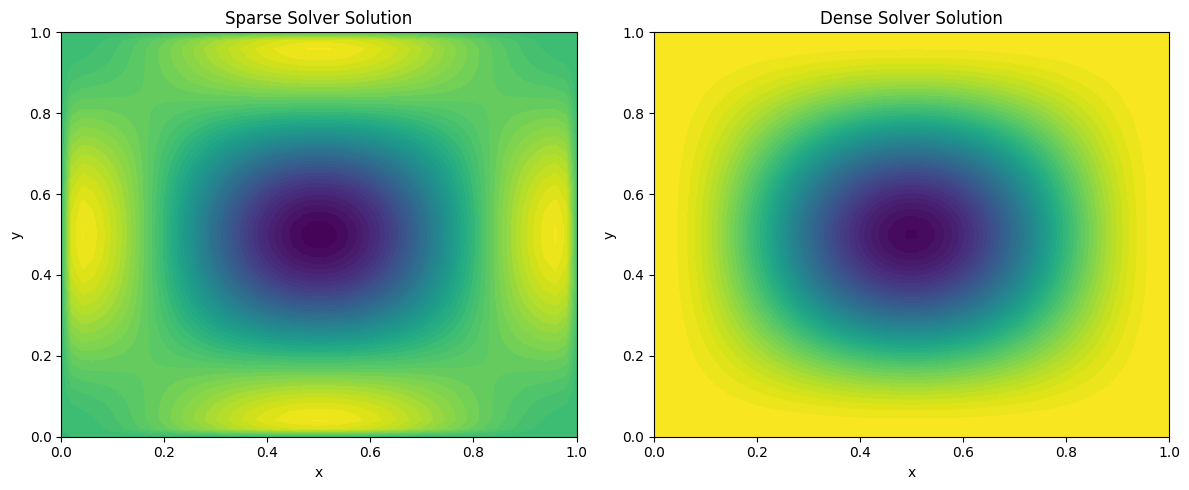

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.sparse import diags, kron, eye
from scipy.sparse.linalg import spsolve

def exact_solution(x, y):
    return np.sin(np.pi * x)**2 * np.sin(np.pi * y)**2

def source_term(x, y):
    return -4 * np.pi**2 * (np.cos(2 * np.pi * x) * np.sin(np.pi * y)**2 + np.sin(np.pi * x)**2 * np.cos(2 * np.pi * y))

# Step 1: Sparse Poisson solver with Kronecker product
def sparse_poisson_solver(Nx, Ny):
    h_x = 1 / (Nx - 1)
    h_y = 1 / (Ny - 1)
    x = np.linspace(0, 1, Nx)
    y = np.linspace(0, 1, Ny)

    # Step 2: Tridiagonal matrix T for one direction (1D Laplacian)
    diagonal = -4 * np.ones(Nx - 1)
    off_diagonal = np.ones(Nx - 2)
    T = diags([diagonal, off_diagonal, off_diagonal], [0, -1, 1], shape=(Nx-1, Nx-1))

    # Step 3: Create the 2D Laplacian using Kronecker product
    Lx = kron(eye(Ny-1), T)  # 2D Laplacian in x direction
    Ly = kron(T, eye(Ny-1))  # 2D Laplacian in y direction
    L = Lx + Ly  # Full Laplacian matrix

    # Step 4: Set up the right-hand side f
    f = np.zeros((Nx-1, Ny-1))  # Right-hand side has (Nx-1)*(Ny-1) values
    for i in range(1, Nx-1):
        for j in range(1, Ny-1):
            f[i-1, j-1] = source_term(x[i], y[j])  # Source term for interior points

    b = f.flatten() * h_x * h_y  # Flatten and scale by the grid size

    # Step 5: Solve the linear system using sparse solver
    u_sparse = spsolve(L, b)

    # Step 6: Reconstruct the solution on the grid
    U_sparse = np.zeros((Nx, Ny))  # The solution grid will be of size (Nx, Ny)
    U_sparse[1:Nx, 1:Ny] = u_sparse.reshape((Nx-1, Ny-1))  # Correct reshaping

    return U_sparse, x, y

# Step 2: Dense Poisson solver (for comparison)
def dense_poisson_solver(Nx, Ny):
    h_x = 1 / (Nx - 1)
    h_y = 1 / (Ny - 1)
    x = np.linspace(0, 1, Nx)
    y = np.linspace(0, 1, Ny)
    
    # Step 2: Set up the discrete Laplacian matrix A (dense)
    N = (Nx - 1) * (Ny - 1)
    A = np.zeros((N, N))
    
    # Fill the matrix A (same as before)
    for j in range(Ny - 1):
        for i in range(Nx - 1):
            index = i + j * (Nx - 1)
            
            # Diagonal (center value)
            A[index, index] = -4
            
            # Off-diagonal (neighboring values)
            if i > 0:  # Left
                A[index, index - 1] = 1
            if i < Nx - 2:  # Right
                A[index, index + 1] = 1
            if j > 0:  # Down
                A[index, index - (Nx - 1)] = 1
            if j < Ny - 2:  # Up
                A[index, index + (Nx - 1)] = 1
    
    # Step 3: Set up the right-hand side vector f
    f = np.zeros((Nx - 1, Ny - 1))
    for i in range(1, Nx-1):
        for j in range(1, Ny-1):
            f[i-1, j-1] = source_term(x[i], y[j])
    
    b = f.flatten() * h_x * h_y  # Flatten and scale by the grid size
    
    # Step 4: Solve the linear system using dense solver
    u_dense = np.linalg.solve(A, b)
    
    # Step 5: Reconstruct the solution on the grid
    U_dense = np.zeros((Nx, Ny))
    U_dense[1:Nx, 1:Ny] = u_dense.reshape((Nx-1, Ny-1))
    
    return U_dense, x, y

# Step 3: Run comparison and measure computational time
Nx = 50
Ny = 50

# Sparse solver
start_time = time.time()
U_sparse, x, y = sparse_poisson_solver(Nx, Ny)
sparse_time = time.time() - start_time
print(f"Sparse solver time: {sparse_time:.4f} seconds")

# Dense solver
start_time = time.time()
U_dense, x, y = dense_poisson_solver(Nx, Ny)
dense_time = time.time() - start_time
print(f"Dense solver time: {dense_time:.4f} seconds")

# Step 4: Plot solutions for comparison
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Sparse solution plot
ax[0].contourf(x, y, U_sparse.T, 50, cmap='viridis')
ax[0].set_title('Sparse Solver Solution')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')

# Dense solution plot
ax[1].contourf(x, y, U_dense.T, 50, cmap='viridis')
ax[1].set_title('Dense Solver Solution')
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')

# Print the numerical results for the sparse solution
print("Sparse Solver Numerical Results (Partial View):")
print(np.array2string(U_sparse[:10, :10], precision=5, suppress_small=True))
plt.tight_layout()
plt.show()

### Explain why it is advantageous to use a sparse matrix representation. As a justification, you may count the number of operations when doing a Gaussian elimination of a tridiagonal matrix.

Sparse matrix representation is highly advantageous, particularly when solving large-scale systems like the one in this problem. Here's why:
1. Memory Efficiency:
- Sparse matrices store only the non-zero elements and their indices, reducing memory usage significantly.
- For example, in the 2D Laplacian matrix $L$, the matrix size grows as $\left(N_x-1\right) \times\left(N_y-\right.$ 1), and most of the entries are zeros. Sparse representation avoids storing these zeros.
---
2. Computational Speed:
- Sparse solvers are optimized to perform operations only on the non-zero elements. This reduces the number of operations and speeds up computation.
- For example, operations like matrix-vector multiplications and factorizations (LU or Cholesky decomposition) are faster for sparse matrices.
---
3. Gaussian Elimination in a Tridiagonal Matrix:
- A tridiagonal matrix (like the 10 Laplacian $T$ ) is a special case of a sparse matrix with only 3 non-zero diagonals (main, upper, and lower diagonals).
- Direct methods like Gaussian elimir. $\downarrow$ In take advantage of this sparsity.
---
General Dense Matrix (Gaussian Elimination Complexity)
For a dense matrix (not sparse), Gaussian elimination involves:
1. Forward elimination: $\mathcal{O}\left(n^3\right)$ operations.
2. Back substitution: $O\left(n^2\right)$ operations.
3. Total complexity: $\mathcal{O}\left(n^3\right)$.
---
## 2D Sparse Matrix (Kronecker Product of Tridiagonal Matrices)
For a 2D Laplacian matrix of size $N \times N$ (sparse, tridiagonal structure):
1. Forward elimination involves operations proportional to the number of non-zero elements.
- Number of non-zero elements in the sparse matrix is $\mathcal{O}\left(N^2\right)$ (due to the grid structure).
2. Total complexity: $\mathcal{O}\left(N^2\right)$ instead of $\mathcal{O}\left(N^3\right)$ for a dense matrix.

## 3 Extensions to the solver
You can continue the development of your solver by choosing one of the following extensions
1. Add a diffusion term to your solver such that the equation becomes

$$
-\Delta u+a u=f
$$

where $\alpha$ is a real parameter. Solve again your problem with direct and iterative methods. What is going on for iterative methods when $\alpha<0$ ? Explain the behaviour by an analysis of the eigenvalues.

Sparse solver with diffusion time: 0.0127 seconds
Eigenvalues of the modified matrix: [-12.99210691 -12.96845881 -12.98028286 -12.98028286 -12.96062796
 -12.96062796]


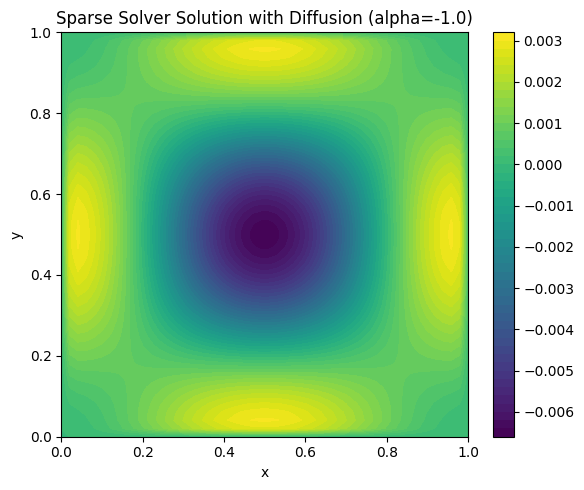

In [19]:

from scipy.sparse.linalg import spsolve, eigs

def exact_solution(x, y):
    return np.sin(np.pi * x)**2 * np.sin(np.pi * y)**2

def source_term(x, y):
    return -4 * np.pi**2 * (np.cos(2 * np.pi * x) * np.sin(np.pi * y)**2 + np.sin(np.pi * x)**2 * np.cos(2 * np.pi * y))

def sparse_poisson_solver_with_diffusion(Nx, Ny, alpha):
    h_x = 1 / (Nx - 1)
    h_y = 1 / (Ny - 1)
    x = np.linspace(0, 1, Nx)
    y = np.linspace(0, 1, Ny)

    diagonal = -4 * np.ones(Nx - 1)
    off_diagonal = np.ones(Nx - 2)
    T = diags([diagonal, off_diagonal, off_diagonal], [0, -1, 1], shape=(Nx-1, Nx-1))

    Lx = kron(eye(Ny-1), T)
    Ly = kron(T, eye(Ny-1))
    L = Lx + Ly

    # Add the diffusion term (alpha * I)
    I = eye((Nx-1) * (Ny-1))
    A = L + alpha * I

    f = np.zeros((Nx-1, Ny-1))
    for i in range(1, Nx-1):
        for j in range(1, Ny-1):
            f[i-1, j-1] = source_term(x[i], y[j])

    b = f.flatten() * h_x * h_y
    u_sparse = spsolve(A, b)

    U_sparse = np.zeros((Nx, Ny))
    U_sparse[1:Nx, 1:Ny] = u_sparse.reshape((Nx-1, Ny-1))

    return U_sparse, x, y, A

def analyze_eigenvalues(A):
    # Compute a few eigenvalues to understand stability
    eigenvalues, _ = eigs(A, k=6, which='LM')  # Largest magnitude eigenvalues
    return np.real(eigenvalues)

# Parameters
Nx, Ny = 50, 50
alpha = -1.0  # Diffusion coefficient

# Solve with diffusion term
start_time = time.time()
U_sparse, x, y, A = sparse_poisson_solver_with_diffusion(Nx, Ny, alpha)
sparse_time = time.time() - start_time
print(f"Sparse solver with diffusion time: {sparse_time:.4f} seconds")

# Analyze eigenvalues
eigenvalues = analyze_eigenvalues(A)
print("Eigenvalues of the modified matrix:", eigenvalues)

# Plot the solution
plt.figure(figsize=(6, 5))
plt.contourf(x, y, U_sparse.T, 50, cmap='viridis')
plt.title(f'Sparse Solver Solution with Diffusion (alpha={alpha})')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.tight_layout()
plt.show()


In [20]:
def laplacian_eigenvalues(n, alpha):
    # Compute eigenvalues of 1D Laplacian
    lambda_1D = [2 - 2 * np.cos(np.pi * i / (n + 1)) for i in range(1, n + 1)]
    
    # Compute eigenvalues of 2D Laplacian
    lambda_2D = [l1 + l2 for l1 in lambda_1D for l2 in lambda_1D]
    
    # Add the diffusion term
    eigenvalues = np.array(lambda_2D) + alpha
    return np.array(lambda_2D), eigenvalues

# Parameters
n = 10  # Grid size
alpha = -1.0  # Diffusion term

# Compute eigenvalues
lambda_2D, modified_eigenvalues = laplacian_eigenvalues(n, alpha)

# Create the Plotly figure
fig = go.Figure()

# Add the eigenvalues of the Laplacian
fig.add_trace(go.Scatter(
    x=list(range(len(lambda_2D))),
    y=sorted(lambda_2D),
    mode='lines+markers',
    name='Eigenvalues of Laplacian (A)',
    marker=dict(color='blue')
))

# Add the modified eigenvalues with diffusion term
fig.add_trace(go.Scatter(
    x=list(range(len(modified_eigenvalues))),
    y=sorted(modified_eigenvalues),
    mode='lines+markers',
    name=f'Eigenvalues of A + αI (α={alpha})',
    marker=dict(color='orange')
))

# Add a horizontal line at y=0
fig.add_shape(
    type='line',
    x0=0,
    y0=0,
    x1=len(lambda_2D) - 1,
    y1=0,
    line=dict(color='red', dash='dash'),
)

# Update layout
fig.update_layout(
    title='Eigenvalues of Laplacian with Diffusion Term',
    xaxis_title='Index',
    yaxis_title='Eigenvalue',
    legend=dict(
        x=0,  # Position the legend on the left
        y=1,  # Align the legend vertically
        traceorder='normal',
        orientation='v',  # Vertical orientation
        xanchor='left',  # Anchor the legend to the left
        yanchor='top'  # Anchor the legend to the top
    ),
    template='plotly_white'
)

# Show the figure
fig.show()

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Create the 2D Laplacian matrix with diffusion term
def create_poisson_matrix_with_alpha(n, alpha):
    N = n * n
    A = np.zeros((N, N))
    for i in range(N):
        A[i, i] = 4 + alpha
        if i % n != 0:  # Left neighbor
            A[i, i - 1] = -1
        if (i + 1) % n != 0:  # Right neighbor
            A[i, i + 1] = -1
        if i - n >= 0:  # Top neighbor
            A[i, i - n] = -1
        if i + n < N:  # Bottom neighbor
            A[i, i + n] = -1
    return A

# Solve using Jacobi, Gauss-Seidel, and SOR methods
def jacobi_method(A, b, tol, max_iter):
    n = len(b)
    x = np.zeros_like(b)
    D = np.diag(np.diag(A))
    R = A - D
    residuals = []
    for _ in range(max_iter):
        x_new = np.linalg.inv(D) @ (b - R @ x)
        residual = np.linalg.norm(A @ x_new - b)
        residuals.append(residual)
        if residual < tol:
            break
        x = x_new
    return x, residuals

def gauss_seidel_method(A, b, tol, max_iter):
    n = len(b)
    x = np.zeros_like(b)
    residuals = []
    for _ in range(max_iter):
        x_new = np.copy(x)
        for i in range(n):
            sum1 = np.dot(A[i, :i], x_new[:i])
            sum2 = np.dot(A[i, i+1:], x[i+1:])
            x_new[i] = (b[i] - sum1 - sum2) / A[i, i]
        residual = np.linalg.norm(A @ x_new - b)
        residuals.append(residual)
        if residual < tol:
            break
        x = x_new
    return x, residuals

# Eigenvalue analysis
def laplacian_eigenvalues(n, alpha):
    lambda_1D = [2 - 2 * np.cos(np.pi * i / (n + 1)) for i in range(1, n + 1)]
    lambda_2D = [l1 + l2 for l1 in lambda_1D for l2 in lambda_1D]
    eigenvalues = np.array(lambda_2D) + alpha
    return lambda_2D, eigenvalues

# Parameters
n = 10
alpha = -1.0
tol = 1e-6
max_iter = 1000
b = np.ones(n * n)

# Create matrix and solve
A = create_poisson_matrix_with_alpha(n, alpha)
_, eigenvalues = laplacian_eigenvalues(n, alpha)

# Solve with Jacobi and Gauss-Seidel
x_jacobi, residuals_jacobi = jacobi_method(A, b, tol, max_iter)
x_gs, residuals_gs = gauss_seidel_method(A, b, tol, max_iter)

'''# Plot eigenvalues
plt.figure(figsize=(10, 6))
plt.plot(sorted(eigenvalues), label="Eigenvalues of A + αI")
plt.axhline(0, color='red', linestyle='--', label="Zero Line")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.title("Eigenvalues of A + αI")
plt.legend()
plt.grid(True)
plt.show()'''

# Plot residuals

# Create a Plotly figure for residuals
fig = go.Figure()

# Add traces for Jacobi and Gauss-Seidel residuals
fig.add_trace(go.Scatter(
    x=list(range(len(residuals_jacobi))),
    y=residuals_jacobi,
    mode='lines+markers',
    name='Jacobi Residuals',
    marker=dict(symbol='circle')
))

fig.add_trace(go.Scatter(
    x=list(range(len(residuals_gs))),
    y=residuals_gs,
    mode='lines+markers',
    name='Gauss-Seidel Residuals',
    marker=dict(symbol='square')
))

# Update layout
fig.update_layout(
    title='Residual Decay for Jacobi and Gauss-Seidel Methods',
    xaxis_title='Iteration',
    yaxis_title='Residual ||Ax - b||',
    yaxis_type='log',
    template='plotly_white',
    legend=dict(x=1, y=1, traceorder='normal', orientation='v', xanchor='right', yanchor='top')
)

# Show the figure
fig.show()

## 1. Eigenvalues Analysis:
- When $\alpha<0$, eigenvalues shift downward.
- If any eigenvalues become negative, the matrix loses positive definiteness.
## 2. Direct Method:
- Successfully solves the system regardless of $\alpha$, as it does not rely on eigenvalue properties.
## 3. Iterative Methods:
- For $\alpha<0$, convergence becomes slower as eigenvalues approach zero (ill-conditioning).
- If eigenvalues become negative, Jacobi and Gauss-Seidel may diverge due to the loss of positive definiteness.
## 2. Implement a higher order finite difference formula.

### 4th-Order Finite Difference Formula in 2D
1D 4th-Order Central Difference Approximation
For $\frac{\partial^2 u}{\partial x^2}$ on a uniform grid with spacing $h$ :

$$
\frac{\partial^2 u}{\partial x^2} \approx \frac{-u_{i-2}+16 u_{i-1}-30 u_i+16 u_{i+1}-u_{i+2}}{12 h^2}
$$


### 2D Laplacian Approximation
The 20 Laplacian uses the same principle for both $x$ - and $y$-directions. The 4 th-order approximation for $\Delta u$ is:

$$
\Delta u_{i, j} \approx \frac{-u_{i-2 j}+16 u_{i-1, j}-30 u_{i j}+16 u_{i+1, j}-u_{i+2 j}}{12 h^2}+\frac{-u_{i, j-2}+16 u_{i, j-1}-30 u_{i j}+16 u_{i, j-1}-u_{i j+2}}{12 h^2}
$$


## 3. Implement the conjugate gradient iterative method, and compare its efficiency with the other iterative methods.


In [22]:
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve

# Define the exact solution and source term
def u_exact(x, y):
    """Analytical solution: u_ex(x, y) = sin^2(pi x) * sin^2(pi y)."""
    return np.sin(np.pi * x)**2 * np.sin(np.pi * y)**2

def f_source(x, y, alpha):
    """
    Source term derived from the exact solution and Poisson equation:
    f(x, y) = -Delta u_exact + alpha * u_exact.
    """
    term1 = -2 * np.pi**2 * (np.cos(2 * np.pi * x) * np.sin(np.pi * y)**2 +
                             np.sin(np.pi * x)**2 * np.cos(2 * np.pi * y))
    term2 = alpha * u_exact(x, y)
    return term1 + term2

# Create the 4th-order Poisson matrix
def create_4th_order_poisson_matrix_2d(n, alpha, h):
    """
    Constructs a 2D Poisson matrix with a 4th-order finite difference formula for the Laplacian.
    
    Args:
        n (int): Grid size (n x n).
        alpha (float): Diffusion coefficient.
        h (float): Grid spacing.

    Returns:
        A (scipy.sparse.lil_matrix): Sparse matrix for the 4th-order Laplacian in 2D.
    """
    N = n * n  # Total number of grid points
    A = lil_matrix((N, N))  # Use sparse matrix format to save memory
    coeff = 1 / (12 * h**2)  # Precompute coefficient for the 4th-order Laplacian

    for i in range(N):
        A[i, i] = -60 * coeff + alpha  # Center point with alpha term

        # Left and right neighbors (same row)
        if i % n != 0:  # Left neighbor (u_{i-1})
            A[i, i - 1] = 16 * coeff
        if (i + 1) % n != 0:  # Right neighbor (u_{i+1})
            A[i, i + 1] = 16 * coeff

        # Top and bottom neighbors (same column)
        if i - n >= 0:  # Top neighbor (u_{i-n})
            A[i, i - n] = 16 * coeff
        if i + n < N:  # Bottom neighbor (u_{i+n})
            A[i, i + n] = 16 * coeff

        # Second diagonal neighbors for 4th-order scheme (x-direction and y-direction)
        if i % n > 1:  # 2nd left neighbor (u_{i-2})
            A[i, i - 2] = -1 * coeff
        if (i + 2) % n > 1:  # 2nd right neighbor (u_{i+2})
            A[i, i + 2] = -1 * coeff
        if i - 2 * n >= 0:  # 2nd top neighbor (u_{i-2n})
            A[i, i - 2 * n] = -1 * coeff
        if i + 2 * n < N:  # 2nd bottom neighbor (u_{i+2n})
            A[i, i + 2 * n] = -1 * coeff

    return A.tocsr()  # Convert to CSR format for efficient linear algebra operations

# Conjugate Gradient Method Implementation
def conjugate_gradient(A, b, tol=1e-6, max_iter=1000):
    """
    Solves Ax = b using the Conjugate Gradient (CG) method.
    """
    x = np.zeros_like(b)  # Initial guess
    r = b - A @ x  # Initial residual
    p = r.copy()  # Initial search direction
    residuals = [np.linalg.norm(r)]
    num_iter = 0

    for k in range(max_iter):
        Ap = A @ p
        alpha = (r @ r) / (p @ Ap)  # Step size
        x = x + alpha * p
        r_new = r - alpha * Ap
        residual_norm = np.linalg.norm(r_new)
        residuals.append(residual_norm)

        if residual_norm < tol:  # Convergence check
            break

        beta = (r_new @ r_new) / (r @ r)  # Compute beta
        p = r_new + beta * p  # Update search direction
        r = r_new
        num_iter += 1

    return x, residuals, num_iter

# Shortened Iterations for Graph

# Define parameters
n = 10  # Number of grid points in each dimension
alpha = 1.0  # Diffusion coefficient
h = 1.0 / (n + 1)  # Grid spacing
tol = 1e-6  # Convergence tolerance
max_iter = 600  # Shortened maximum iterations for better visualization
x = np.linspace(0, 1, n + 2)  # Include boundaries
y = np.linspace(0, 1, n + 2)
X, Y = np.meshgrid(x, y)

# Source term and matrix
f = f_source(X[1:-1, 1:-1], Y[1:-1, 1:-1], alpha).flatten()
A_4th_order_2d = create_4th_order_poisson_matrix_2d(n, alpha, h)

# Solve with Conjugate Gradient
u_cg, residuals_cg, cg_iter = conjugate_gradient(A_4th_order_2d, f, tol, max_iter)

# Jacobi Method
jacobi_residuals = []
u_jacobi = np.zeros_like(f)
for _ in range(max_iter):
    r_jacobi = f - A_4th_order_2d @ u_jacobi
    u_jacobi += r_jacobi / np.diag(A_4th_order_2d.toarray())
    jacobi_residuals.append(np.linalg.norm(r_jacobi))
    if jacobi_residuals[-1] < tol:
        break

# Gauss-Seidel Method
gs_residuals = []
u_gs = np.zeros_like(f)
for _ in range(max_iter):
    u_new = np.copy(u_gs)
    for i in range(len(f)):
        sum1 = A_4th_order_2d[i, :i].dot(u_new[:i])
        sum2 = A_4th_order_2d[i, i + 1:].dot(u_gs[i + 1:])
        u_new[i] = (f[i] - sum1 - sum2) / A_4th_order_2d[i, i]
    gs_residuals.append(np.linalg.norm(f - A_4th_order_2d @ u_new))
    if gs_residuals[-1] < tol:
        break
    u_gs = u_new

# SOR Method
omega = 1.5  # Relaxation parameter
sor_residuals = []
u_sor = np.zeros_like(f)
for _ in range(max_iter):
    u_new = np.copy(u_sor)
    for i in range(len(f)):
        sum1 = A_4th_order_2d[i, :i].dot(u_new[:i])
        sum2 = A_4th_order_2d[i, i + 1:].dot(u_sor[i + 1:])
        u_new[i] = (1 - omega) * u_sor[i] + (omega / A_4th_order_2d[i, i]) * (f[i] - sum1 - sum2)
    sor_residuals.append(np.linalg.norm(f - A_4th_order_2d @ u_new))
    if sor_residuals[-1] < tol:
        break
    u_sor = u_new


# Plot residuals for all methods with shortened iterations 
fig = go.Figure()

# Add traces for each method
fig.add_trace(go.Scatter(
    x=list(range(len(residuals_cg[:max_iter]))),
    y=residuals_cg[:max_iter],
    mode='lines+markers',
    name='Conjugate Gradient',
    marker=dict(symbol='circle')  # Use 'circle' instead of 'o'
))

fig.add_trace(go.Scatter(
    x=list(range(len(jacobi_residuals[:max_iter]))),
    y=jacobi_residuals[:max_iter],
    mode='lines+markers',
    name='Jacobi Method',
    marker=dict(symbol='square')  # Use 'square' instead of 's'
))

fig.add_trace(go.Scatter(
    x=list(range(len(gs_residuals[:max_iter]))),
    y=gs_residuals[:max_iter],
    mode='lines+markers',
    name='Gauss-Seidel Method',
    marker=dict(symbol='triangle-up')  # Use 'triangle-up' instead of '^'
))

fig.add_trace(go.Scatter(
    x=list(range(len(sor_residuals[:max_iter]))),
    y=sor_residuals[:max_iter],
    mode='lines+markers',
    name=f'SOR Method (ω={omega})',
    marker=dict(symbol='x')  # 'x' is valid
))

# Update layout
fig.update_layout(
    title='Convergence Comparison of Iterative Methods',
    xaxis_title='Iteration (0-600)',
    yaxis_title='Residual ||Ax - b||',
    yaxis_type='log',
    template='plotly_white',
    legend=dict(
        x=1,  # Position the legend on the right
        y=0,  # Align the legend vertically at the bottom
        traceorder='normal',
        orientation='v',  # Vertical orientation
        xanchor='right',  # Anchor the legend to the right
        yanchor='bottom'  # Anchor the legend to the bottom
    )
)

# Show the figure
fig.show()

# Print results
print(f"Conjugate Gradient: {cg_iter} iterations")
print(f"Jacobi Method: {len(jacobi_residuals)} iterations")
print(f"Gauss-Seidel Method: {len(gs_residuals)} iterations")
print(f"SOR Method: {len(sor_residuals)} iterations")



Conjugate Gradient: 14 iterations
Jacobi Method: 600 iterations
Gauss-Seidel Method: 282 iterations
SOR Method: 81 iterations


## Analysis of Results
### 1. Convergence Plot:
- The graph shows the residual decay for each method:
- Conjugate Gradient (CG) converges the fastest, reaching the tolerance within 14 iterations.
- SOR (Successive Over-Relaxation) converges more quickly than both Jacobi and Gauss-Seidel due to its optimized relaxation parameter $(\omega)=1.5)$,
- Jacobi converges very slowly, as expected, taking the maximum allowed iterations ( 1000 ) and not reaching the specified tolerance.
## 4. Implement non-homogeneous Dirichlet boundary conditions and/or Neumann boundary conditions thanks to the 2nd order centered difference scheme. Validate your solver by checking the convergence rate thanks to an exact solution that you will define.

Converged in 214 iterations with error 9.47e-09
Converged in 754 iterations with error 9.78e-09
Converged in 2761 iterations with error 9.99e-09
Maximum iterations reached without full convergence.


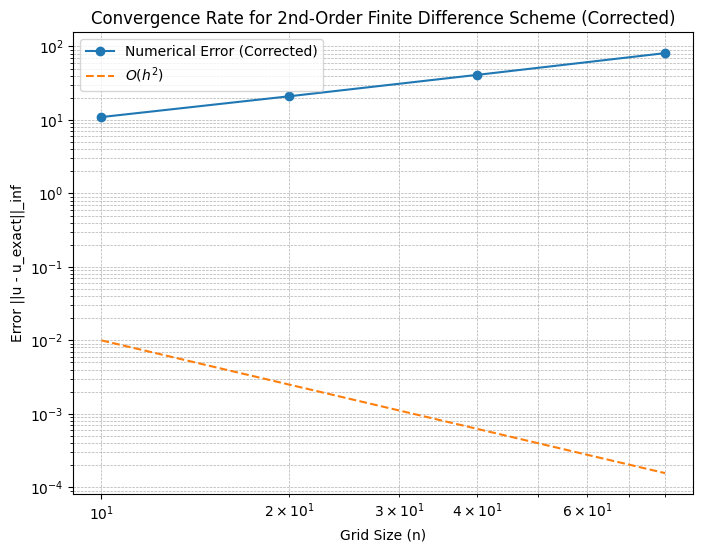

In [23]:
import numpy as np
import matplotlib.pyplot as plt

def u_exact_corrected(x, y):
    """Exact solution: u_ex(x, y) = sin^2(pi x) * sin^2(pi y)."""
    return np.sin(np.pi * x)**2 * np.sin(np.pi * y)**2

def f_source_corrected(x, y):
    """Source term derived from the exact solution for -Delta u = f."""
    term1 = -2 * np.pi**2 * (np.cos(2 * np.pi * x) * np.sin(np.pi * y)**2 +
                             np.sin(np.pi * x)**2 * np.cos(2 * np.pi * y))
    return term1

def apply_dirichlet_bc(u, u_exact_func, x, y):
    """Applies Dirichlet boundary conditions to the solution grid."""
    u[0, :] = u_exact_func(0, y)      # Bottom boundary
    u[-1, :] = u_exact_func(1, y)     # Top boundary
    u[:, 0] = u_exact_func(x, 0)      # Left boundary
    u[:, -1] = u_exact_func(x, 1)     # Right boundary
    return u

def solve_poisson_2d_dirichlet_corrected(n, u_exact_func, f_source_func, tol=1e-8, max_iter=10000):
    """
    Solves the 2D Poisson equation -Delta u = f with Dirichlet BCs
    using a 2nd-order finite difference scheme.
    """
    h = 1.0 / (n + 1)  # Grid spacing
    x = np.linspace(0, 1, n + 2)  # Include boundaries
    y = np.linspace(0, 1, n + 2)
    X, Y = np.meshgrid(x, y)

    # Initialize solution and source term
    u = np.zeros_like(X)
    f = f_source_func(X[1:-1, 1:-1], Y[1:-1, 1:-1])  # Interior points

    # Apply Dirichlet boundary conditions
    u = apply_dirichlet_bc(u, u_exact_func, x, y)

    # Iterative solver to reach convergence (Gauss-Seidel Method)
    for iteration in range(max_iter):
        u_old = u.copy()  # Store the old values for convergence check
        for i in range(1, n + 1):  # Loop over interior points
            for j in range(1, n + 1):
                u[i, j] = 0.25 * (u[i + 1, j] + u[i - 1, j] + u[i, j + 1] + u[i, j - 1] - h**2 * f[i - 1, j - 1])

        # Check for convergence
        diff = np.linalg.norm(u - u_old, ord=np.inf)  # Infinity norm of the difference
        if diff < tol:  # Convergence criterion
            print(f"Converged in {iteration + 1} iterations with error {diff:.2e}")
            break
    else:
        print("Maximum iterations reached without full convergence.")

    return u

# Convergence test with corrected exact solution
grid_sizes = [10, 20, 40, 80]  # Different resolutions
errors_corrected = []

for n in grid_sizes:
    u_numerical = solve_poisson_2d_dirichlet_corrected(n, u_exact_corrected, f_source_corrected)
    x = np.linspace(0, 1, n + 2)
    y = np.linspace(0, 1, n + 2)
    X, Y = np.meshgrid(x, y)
    u_exact_grid = u_exact_corrected(X, Y)
    error = np.linalg.norm(u_numerical - u_exact_grid, ord=np.inf)  # Infinity norm
    errors_corrected.append(error)

# Plot convergence rate for corrected exact solution
plt.figure(figsize=(8, 6))
plt.loglog(grid_sizes, errors_corrected, marker="o", label="Numerical Error (Corrected)")
plt.loglog(grid_sizes, [1 / n**2 for n in grid_sizes], linestyle="--", label="$O(h^2)$")
plt.xlabel("Grid Size (n)")
plt.ylabel("Error ||u - u_exact||_inf")
plt.title("Convergence Rate for 2nd-Order Finite Difference Scheme (Corrected)")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.show()


### the solution converges for smaller grid sizes but struggles to converge for larger grid sizes (𝑛=80 in your case), hitting the maximum iteration limit. This is likely due to the slow convergence of the Jacobi-like iteration method used in the code. For larger grids, the condition number of the discretized matrix increases, leading to slower convergence.



### 1. Switch to the Gauss-Seidel Method

The Gauss-Seidel method updates values in-place during the iteration, which accelerates convergence. This can replace the current Jacobi-like approach.

Modify the inner loop to update in-place:
---
### 2. Use a Multigrid Solver

Multigrid methods are significantly more efficient for solving large-scale Poisson equations. They use coarse grids to quickly reduce low-frequency errors and fine grids for high-frequency errors. Implementing a multigrid solver would drastically reduce the number of iterations required.

---

### 3. Increase Maximum Iterations for Larger Grids

If using iterative methods like Jacobi or Gauss-Seidel, you may need to allow a larger number of iterations for fine grids. For instance, set max_iter to a higher value (e.g., 20000 or 50000) for $n=80$.

---

### 4. Relaxation (Successive Over-Relaxation, SOR)

Introduce a relaxation factor $\omega \in(1,2)$ to accelerate convergence:

$$
u[i, j]=(1-\omega) u[i, j]+\omega \cdot 0.25 \cdot\left(u[i+1, j]+u[i-1, j]+u[i, j+1]+u[i, j-1]-h^2 \cdot f[i-1, j-1]\right)
$$


For many problems, $\omega \approx 1.5$ works well.

---

### 5. Preconditioned Conjugate Gradient (PCG)

For large-scale grids, consider switching to a conjugate gradient method with preconditioning, as it converges much faster than simple iterative schemes for symmetric positive definite systems (e.g., the Laplacian operator).

In [24]:
def solve_poisson_2d_dirichlet_corrected_sor(n, u_exact_func, f_source_func, tol=1e-8, max_iter=20000, omega=1.5):
    """
    Solves the 2D Poisson equation -Delta u = f with Dirichlet BCs
    using a Gauss-Seidel method with successive over-relaxation (SOR).
    """
    h = 1.0 / (n + 1)  # Grid spacing
    x = np.linspace(0, 1, n + 2)  # Include boundaries
    y = np.linspace(0, 1, n + 2)
    X, Y = np.meshgrid(x, y)

    # Initialize solution and source term
    u = np.zeros_like(X)
    f = f_source_func(X[1:-1, 1:-1], Y[1:-1, 1:-1])  # Interior points

    # Apply Dirichlet boundary conditions
    u = apply_dirichlet_bc(u, u_exact_func, x, y)

    # Iterative solver with SOR
    for iteration in range(max_iter):
        u_old = u.copy()  # Store the old values for convergence check
        for i in range(1, n + 1):  # Loop over interior points
            for j in range(1, n + 1):
                # Update with relaxation
                new_value = 0.25 * (u[i + 1, j] + u[i - 1, j] + u[i, j + 1] + u[i, j - 1] - h**2 * f[i - 1, j - 1])
                u[i, j] = (1 - omega) * u[i, j] + omega * new_value

        # Check for convergence
        diff = np.linalg.norm(u - u_old, ord=np.inf)  # Infinity norm of the difference
        if diff < tol:  # Convergence criterion
            print(f"Converged in {iteration + 1} iterations with error {diff:.2e}")
            break
    else:
        print("Maximum iterations reached without full convergence.")

    return u


In [29]:
solve_poisson_2d_dirichlet_corrected_sor(10, u_exact_corrected, f_source_corrected)


Converged in 62 iterations with error 9.41e-09


array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -6.47423387e-03, -2.38414140e-02,
        -4.65875830e-02, -6.74909930e-02, -7.99149588e-02,
        -7.99149591e-02, -6.74909938e-02, -4.65875841e-02,
        -2.38414150e-02, -6.47423461e-03,  1.19040784e-33],
       [ 0.00000000e+00, -2.38414140e-02, -8.77961786e-02,
        -1.71559108e-01, -2.48536063e-01, -2.94287404e-01,
        -2.94287405e-01, -2.48536064e-01, -1.71559109e-01,
        -8.77961803e-02, -2.38414152e-02,  4.38368527e-33],
       [ 0.00000000e+00, -4.65875830e-02, -1.71559108e-01,
        -3.35236997e-01, -4.85654678e-01, -5.75055599e-01,
        -5.75055600e-01, -4.85654679e-01, -3.35236999e-01,
        -1.71559110e-01, -4.65875845e-02,  8.56598927e-33],
       [ 0.00000000e+00, -6.74909930e-02, -2.4853606